# Project 3

Import some libraries and the datasets

In [343]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv # because it is experimental we need this
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from ISLP import load_data, confusion_table
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, log_loss, mean_squared_error,confusion_matrix, classification_report,balanced_accuracy_score, max_error, PredictionErrorDisplay,mean_absolute_error, mean_absolute_percentage_error)
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier)
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from IPython.display import Image, Markdown
import graphviz
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
import re
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict

In [353]:
# no idea what this is
#data_index_example = pd.read_csv('../Project_datasets/data_index - example.csv')
# LPJ_GUESS_output = pd.read_csv('../Project_datasets/LPJ-GUESS_output_BERN1.csv')
# LPJ_GUESS_output = LPJ_GUESS_output.set_index(['Lon','Lat']).sort_index()
# main dataset
data_index_2 = pd.read_csv('../Project_datasets/data_index_2.csv', quotechar="'")
data_index_2 = data_index_2.drop(columns=['Unnamed: 0'])
# data_index_2 = data_index_2.set_index(['Lon','Lat']).sort_index()
# LPJ_GUESS_output = LPJ_GUESS_output[~(data_index_2.isna().any(axis=1))] # delete rows with NaN
data_index_2 = data_index_2[~(data_index_2.isna().any(axis=1))] # delete rows with NaN
# precipitation by day and statistics
if False:
    Predaymean = pd.read_csv('../Project_datasets/Predaymean1961_1990.csv')
    Predaymean_statistics = pd.read_csv('../Project_datasets/Predaymean1961_1990_statics.csv')
    # maximum temperature by day and statistics
    Tmaxdaymean = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990.csv')
    Tmaxdaymean_statistics = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990_statics.csv')
    # minimum temperature by day and statistics
    Tmindaymean = pd.read_csv('../Project_datasets/Tmindaymean1961_1990.csv')
    Tmindaymean_statistics = pd.read_csv('../Project_datasets/Tmindaymean1961_1990_statics.csv')
    # mean temperature by day and statistics
    Tmpdaymean = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990.csv')
    Tmpdaymean_statistics = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990_statics.csv')
    # shortwave radiation flux
    Tswrfdaymean = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990.csv')
    Tswrfdaymean_statistics = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990_statics.csv')

In [354]:
gridlist_pan_gfed_ISO3_UN = open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt','r')

Show the first entries

### Main Data set

Short legend about the colums: 

Lon: Longitude<br>
Lat: Latidude

stuff about the souil texture: <br>

clay: Clay in %<br>
silt: Silt in % (sedimentary deposit that is formed when a river deposits the material it is carrying)<br>
slay: slay in %(soil in eg. rainforest) <br>
sand: sand in % %<br>
orC: organic carbondioxid in %<br>
CN: Cyanide in %<br>
pH: pH<br>
cell fraction: portion of cells / organic material in soil in % <br>


Allways with season: Same as the tables below.

tmax: maximum temperatur in K <br>
tmin: min temperature in K <br>
tmp:mean temperature in K <br>
Pre: Precipitation, mm day-1 <br>
tswrf: Total shortwave radiation flux, W m-2


This is the GUESS output: 

NPP: net primary productivity (kg C m-2 year-1)<br>
SoilR: soil respiration (kg C m-2 year-1)<br>
MaxBiomeCmass: The maximum biomass from a single biome (kg C m-2)<br>
MxbiomeLAI: The maximum leaf area index from a single biome (unitless)<br>
VegC: Vegetation carbon poo (kg C m-2)l<br>
LitterC: Litter carbon pool (kg C m-2)<br>
SoilC: Soil carbon pool (kg C m-2)<br>
Biome_Cmass: The biome type based on the maximum biomass (category)<br>
Biome_LAI: The biome type based on the maximum LAI (category)<br>
Biome_obs: The observed biome type (category)<br>

Country codes

GFED-region: Global Fire Emissions Database (https://www.un-spider.org/global-fire-emissions-database-gfed) <br>
Pan_2007: Big reogion (Europa, Africa, Australia, USA, Russia, China, .... )<br>
ISO3: Abbreviation for country <br>
UN: Country code

In [355]:
print(f'shape: {data_index_2.shape}')
data_index_2.head()

shape: (59190, 83)


,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,tmax_SpringMean,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN
0,-179.75,71.25,0.08,0.37,0.55,0.020,11.0,5.9,0.482,249.88,...,0.0,0.000,0.000,13,13,17,10,Russia,RUS,643
1,-179.75,68.75,0.20,0.48,0.32,0.031,17.0,6.3,0.753,250.64,...,0.0,0.003,0.015,13,11,17,10,Russia,RUS,643
2,-179.75,68.25,0.20,0.48,0.32,0.031,17.0,6.3,0.447,249.84,...,0.0,0.006,0.022,13,11,17,10,Russia,RUS,643
3,-179.75,67.75,0.20,0.48,0.32,0.031,17.0,6.3,0.526,250.84,...,0.0,0.002,0.020,13,11,17,10,Russia,RUS,643
4,-179.75,67.25,0.20,0.48,0.32,0.031,17.0,6.3,0.422,251.42,...,0.0,0.003,0.016,13,11,17,10,Russia,RUS,643


In [356]:
with open("../Project_datasets/Readme.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if False:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

### LPJ_Guess_output


In [357]:
print(f'shape: {LPJ_GUESS_output.shape}')
LPJ_GUESS_output.head()

shape: (59190, 12)


,Lon,Lat,NPP,SoilR,MaxBiomeCmax,MaxBiomeLAI,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs
0,39.75,-1.25,0.429,0.390,0.449,1.9821,1.225,0.758,5.941,8,12,12
1,150.25,-34.25,0.554,0.451,6.883,3.3174,6.953,3.221,10.566,7,7,6
2,-63.75,82.75,0.000,0.000,0.000,0.0000,0.000,0.003,0.002,13,13,17
3,59.25,30.75,0.043,0.042,0.090,0.2146,0.127,0.084,0.543,7,11,14
4,24.25,27.75,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,13,13,17


### Pred (Precipitation, mm day-1)
 

In [358]:
print(f'shape: {Predaymean.shape}')
#Predaymean.head()

shape: (59191, 367)


In [359]:
print(f'shape: {Predaymean_statistics.shape}')
#Predaymean_statistics.head()

shape: (59191, 14)


### Tmp (Daily mean temperature, K)

In [360]:
print(f'shape: {Tmpdaymean.shape}')
#Tmpdaymean.head()

shape: (59191, 367)


In [361]:
print(f'shape: {Tmpdaymean_statistics.shape}')
#Tmpdaymean_statistics.head()

shape: (59191, 14)


### Tmax

In [362]:
print(f'shape: {Tmaxdaymean.shape}')
#Tmaxdaymean.head()

shape: (59191, 367)


In [363]:
print(f'shape: {Tmaxdaymean_statistics.shape}')
#Tmaxdaymean_statistics.head()

shape: (59191, 14)


### Tmin

In [364]:
print(f'shape: {Tmindaymean.shape}')
#Tmindaymean.head()

shape: (59191, 367)


In [365]:
print(f'shape: {Tmindaymean_statistics.shape}')
#Tmindaymean_statistics.head()

shape: (59191, 14)


### Tswrf (Total shortwave radiation flux, W m-2)

In [366]:
print(f'shape: {Tswrfdaymean.shape}')
#Tswrfdaymean.head()

shape: (59191, 367)


In [367]:
print(f'shape: {Tswrfdaymean_statistics.shape}')
#Tswrfdaymean_statistics.head()

### County List and binome legend

In [368]:
# Read the data from file into a list-of-lists table.
with open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt') as file:
    datatable = [line.split() for line in file.read().splitlines()]

country_codes = pd.DataFrame(datatable, columns = ['Lon', 'Lat', 'GFED-region', 'Pan_2007', 'ISO3', 'UN'] )  
country_codes = country_codes.drop(index = 0)
country_codes.head()

,Lon,Lat,GFED-region,Pan_2007,ISO3,UN
1,-69.75,-55.25,5,Americas,CHL,152
2,-69.25,-55.25,5,Americas,CHL,152
3,-71.25,-54.75,5,Americas,CHL,152
4,-70.75,-54.75,5,Americas,CHL,152
5,-70.25,-54.75,5,Americas,CHL,152


In [369]:
    
with open("../Project_datasets/legend of biomes.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if True:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

1 Boreal decid forest
2 Boreal ever forest
3 Temp/boreal mix fo.
4 Temp conifer forest
5 Temp decid forest
6 Temp broad ever fo.
7 Temp mixed forest
8 Trop season forest
9 Trop rain forest
10 Trop decid forest
11 Moist savannas
12 Dry savannas
13 Tall grassland
14 Dry grassland
15 Xeric wood/shrub
16 Arid shrub/steppe
17 Desert
18 Arctic/alpine tundra


## Some preparations

### number of samples of different biomes in different coutries

In [370]:
countrys_sample_size = data_index_2.groupby(['ISO3', 'Biome_obs']).size()   
#countrys_sample_size = pd.DataFrame(countrys_sample_size)
#countrys_sample_size.columns = [ "Size"]           # Maybe solve later
countrys_sample_size.head()

ISO3  Biome_obs
AGO   6              3
      8            187
      9             25
      10            88
      11             7
dtype: int64

In [371]:
# Samply size for countries
countrys_sample_size.at["EGY"]

Biome_obs
14     34
16     34
17    292
dtype: int64

### Plot and table generation

In [372]:
# Names my have to be improved
def df_to_latex(df, filename = 'mytable', caption=''):  
    s = df.style.to_latex(
    column_format="rrrrr",#  position="h", position_float="centering",
    hrules=True,
    multirow_align="t", multicol_align="r"
    )  
        
    with open('../table/' + filename + '.tex', 'w') as f:
        f.write(s)  
    

In [373]:
## test
df = pd.DataFrame(dict(name=['Raphael', 'Donatello'],
                       age=[26, 45],
                       height=[181.23, 177.65]))

df_to_latex(df, filename = 'ATable')

In [374]:
def save_plot(figure, figurename = 'my_plot'):
    figure.savefig('../plots/' + figurename + '.pdf', bbox_inches='tight')

## test
#save_plot(fig, figurename ='worldmap')

### Plot function for statistics

In [375]:
def plot_statistics(data, name_data = 'data'):
    
    obs_data = "Biome_obs"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = obs_data)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    obs_data = "Biome_Cmax"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = obs_data)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## sample biomes
    obs_data = "Biome_obs_Pan_2007"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = 'Pan_2007', hue = 'Biome_obs')
    ax.tick_params(axis='x', rotation=90)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## sample biomes
    obs_data = "Biome_obs_ISO3"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = 'ISO3', hue = 'Biome_obs')
    ax.tick_params(axis='x', rotation=90)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## scatterplot biome_Cmax and biome_LAI
    obs_data = "Biome_obs_Biome_Cmax"
    fig, ax = plt.subplots(figsize = (4,4))
    ax = sns.scatterplot(data, x = "Biome_Cmax", y = "Biome_obs")
    ax.set_yticks(range(1, 20,2))
    save_plot(fig, figurename = 'scatterplot_' + name_data + '_' + obs_data)
    
    '''
    obs_data = "Biome_obs_Biome_LAI"
    fig, ax = plt.subplots(figsize = (4,4))
    ax = sns.scatterplot(data, x = "Biome_LAI", y = "Biome_obs")
    ax.set_yticks(range(1, 20,2))
    save_plot(fig, figurename = 'scatterplot_' + name_data + '_' + obs_data)
    '''
    
    # NPP
    obs_data = "NPP"
    fig, axs = plt.subplots( 1,2, constrained_layout=True)
    sns.histplot(data, x=obs_data,  kde=True, ax=axs[0]) #stat="density", kde=True,, log_scale=True
    sns.ecdfplot(data, x="NPP", ax=axs[1])
    save_plot(fig, figurename = 'histogramm_' + name_data + '_' + obs_data)
    
    #"VegC"
    obs_data = "VegC"
    fig, axs = plt.subplots(1,2, constrained_layout=True)
    sns.histplot(data, x=obs_data,   kde=True, ax=axs[0]) #stat="density", kde=True,binwidth=1,
    sns.ecdfplot(data, x="VegC", ax=axs[1])
    save_plot(fig, figurename = 'histogramm_' + name_data + '_' + obs_data)

## Section 2: Visualisation


In [376]:
weather_params = ['pre','tmp|tmin|tmax','tswrf']

features_weather = [feature_name for feature_name in list(data_index_2) if \
                   re.search('Fall|Summer|Winter|Spring',feature_name)]

liste = ['Lat', 'Lon', 'UN', 'GFED-region', 'Biome_obs', 'Biome_LAI', 'Biome_Cmax']+features_weather

print(data_index_2.head())
print(data_index_2.drop(liste, axis=1).describe())

      Lon    Lat  clay  silt  sand   orgC    CN   pH  cellfraction  \
0 -179.75  71.25  0.08  0.37  0.55  0.020  11.0  5.9         0.482   
1 -179.75  68.75  0.20  0.48  0.32  0.031  17.0  6.3         0.753   
2 -179.75  68.25  0.20  0.48  0.32  0.031  17.0  6.3         0.447   
3 -179.75  67.75  0.20  0.48  0.32  0.031  17.0  6.3         0.526   
4 -179.75  67.25  0.20  0.48  0.32  0.031  17.0  6.3         0.422   

   tmax_SpringMean  ...  VegC  LitterC  SoilC  Biome_Cmax  Biome_LAI  \
0           249.88  ...   0.0    0.000  0.000          13         13   
1           250.64  ...   0.0    0.003  0.015          13         11   
2           249.84  ...   0.0    0.006  0.022          13         11   
3           250.84  ...   0.0    0.002  0.020          13         11   
4           251.42  ...   0.0    0.003  0.016          13         11   

   Biome_obs  GFED-region  Pan_2007  ISO3   UN  
0         17           10    Russia   RUS  643  
1         17           10    Russia   RUS  643  

Countplot to count the number of data for each biom: 

In [377]:
#sns.scatterplot(data_index_2, x="Lon", y="Lat", hue="Biome_obs")

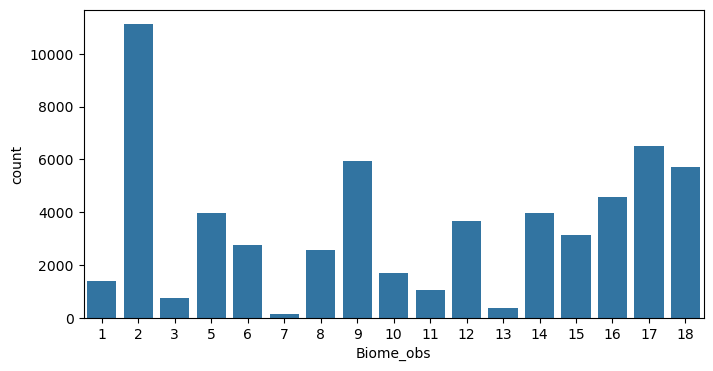

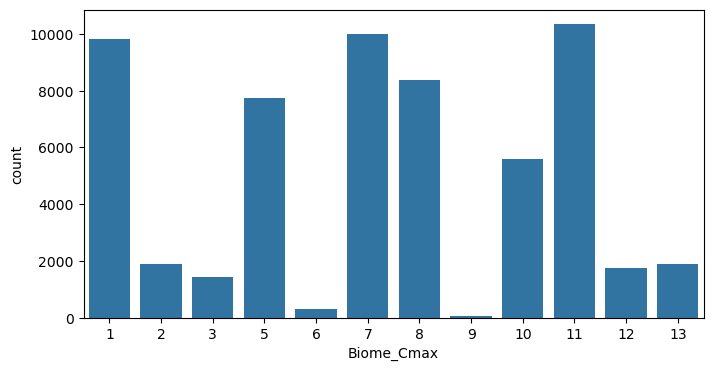

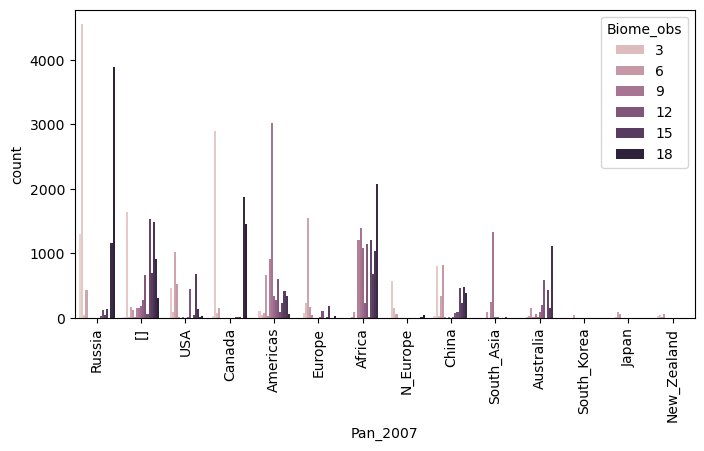

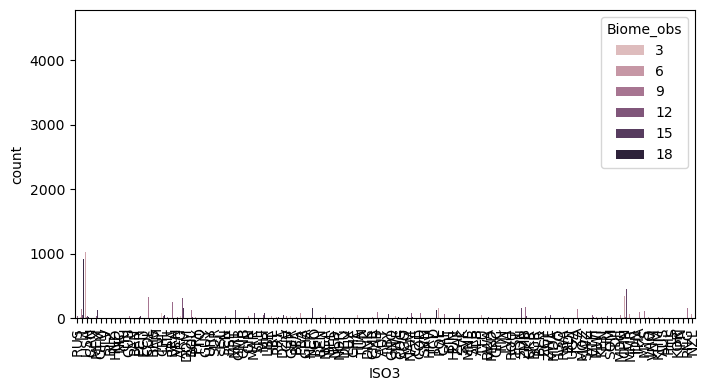

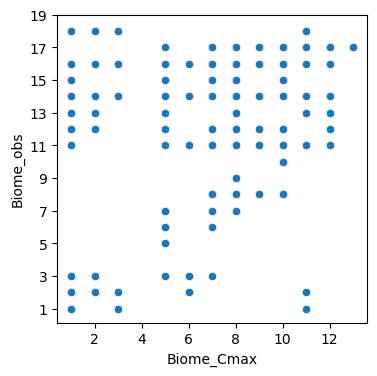

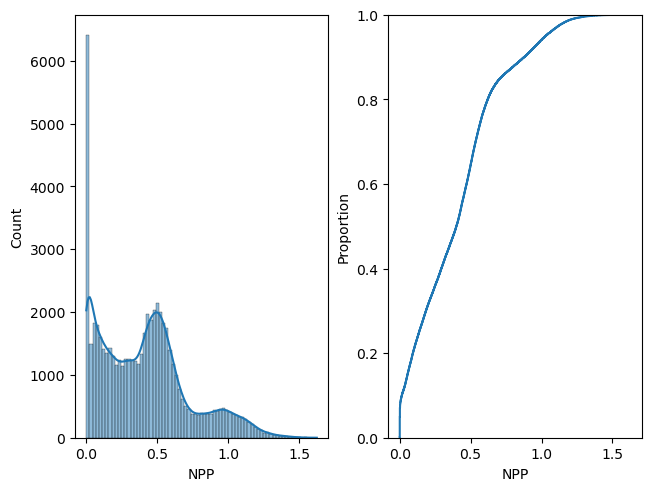

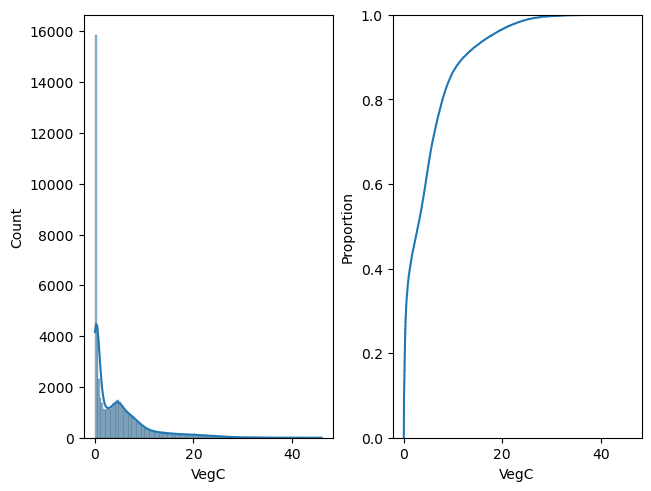

In [378]:
plot_statistics(data_index_2)

Biome with index 4?

In [383]:
data_index_2.loc[data_index_2['Biome_obs'] == 4]

,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,tmax_SpringMean,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN


## Functions for Classifiaction and Regression

### Generate test and train sets

In [384]:
# the following function generates X_test, Y_test and X_train, Y_train for the binary classification
def model_create_XY(region_train, region_test, \
                     drop_columns=[], use_columns=None, \
                        objective='Biome_obs', objective_list=None, continuous_Y=False,
                        objective_test=None):
      
      drop_columns = drop_columns.copy() + [objective] # we would not want our objective to appear in the training data
      if not objective_test: objective_test = objective

      # restrict to two biomes, restrict to country codes, remove any rows with NaN
      if not continuous_Y:
            if not objective_list: objective_list=list(data_index_2.loc[region_train][objective].drop_duplicates())
            relevant_data_train = data_index_2.loc[data_index_2[objective].isin(objective_list)] # restrict to given biomes
            # in case we want to use LPJ_guess output, write LPJ_ before the objective_list
            relevant_data_test = data_index_2.loc[data_index_2[objective_test].isin(objective_list)] # restrict to given biomes
      else:
            relevant_data_train = data_index_2
            relevant_data_test = data_index_2

                  
      relevant_data_train = relevant_data_train.loc[region_train] # restrict to training country
      relevant_data_test = relevant_data_test.loc[region_test] # restrict to test country

      drop_columns += ['MaxBiomeLAI','Biome_obs','Biome_LAI','Biome_Cmax',
                       'Lon','Lat','Pan_2007','ISO3','UN','MaxBiomeCmax'] # drop these columns
      if use_columns:
            X_train = relevant_data_train[use_columns]
            X_test = relevant_data_test[use_columns]
      else:
            X_train = relevant_data_train.drop(columns=drop_columns)
            X_test = relevant_data_test.drop(columns=drop_columns)

      feature_names = list(X_train.columns)

      Y_train = relevant_data_train[objective]
      Y_test = relevant_data_test[objective_test]

      print(f"length of training data: {Y_train.shape[0]}")
      print(f"length of testing data: {Y_test.shape[0]}")
      

      return X_train, X_test, Y_train, Y_test, feature_names

### Plot Feature importance (Permutation importance vs. purity importance)

Important Notes
- The more accurate model is, the more trustworthy computed importances are.
- The computed importances describe how important features are for the machine learning model. It is an approximation of how important features are in the data.


In [385]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y,  n_repeats=10, random_state=42, n_jobs=2) # n_repeats=10, random_state=42, n_jobs=2
    perm_sorted_idx = result.importances_mean.argsort()
    
    x_val = X.columns[perm_sorted_idx]
    y_val = result.importances[perm_sorted_idx].mean(axis=1).T
    
    ax.barh(x_val[-5:], y_val[-5:])
    ax.tick_params(axis='y', which = 'minor', labelsize=10)
    #ax.axvline(x=0, color="k", linestyle="--")
    return ax

def plot_permutation_importance_big_graph(clf, X_train, X_test,  Y_train, Y_test, experiment_name):

    mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    # tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
    # tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))
    y = mdi_importances.sort_values()
    y[-5:].plot.barh(ax=ax1)
    ax1.set_xlabel("Gini importance")
    plot_permutation_importance(clf, X_train, Y_train, ax2)
    ax2.set_xlabel("Decrease in accuracy ")
    #fig.suptitle(
     #   "Impurity-based vs. permutation importances on multicollinear features"
    #)
    plot_permutation_importance(clf, X_test, Y_test, ax3)
    ax3.set_xlabel("Decrease in accuracy")
    _ = fig.tight_layout()
    save_plot(fig, figurename = 'histogramm_feature_imp'+ experiment_name )
    return fig

def clustering(clf, X_train, X_test,  Y_train, Y_test, experiment_name):
    
    
    fig, (ax1) = plt.subplots( figsize=(6,7))
    corr = spearmanr(X_train).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
        dist_linkage, labels=X_train.columns.to_list(), ax=ax1, leaf_rotation=90
    )
    dendro_idx = np.arange(0, len(dendro["ivl"]))
    
    cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    selected_features_names = X_train.columns[selected_features]
    selected_features_names = selected_features_names.tolist()
    
    X_train_sel = X_train[selected_features_names]
    X_test_sel = X_test[selected_features_names]

    clf_sel = clf
    clf_sel.fit(X_train_sel, Y_train)
    print(
        "Baseline accuracy on test data with features removed:"
        f" {accuracy_score(Y_test, clf.predict(X_test_sel)):.4}"
        "Baseline balanced accuracy on test data with features removed:"
        f" {balanced_accuracy_score(Y_test, clf.predict(X_test_sel)):.4}"
    )
    
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_permutation_importance(clf_sel, X_test_sel, Y_test, ax)
    #ax.set_title("Permutation Importances on selected subset of features\n(test set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    save_plot(fig, figurename = 'histogramm_feature_imp_clustered'+ experiment_name )
    plt.show()

### Classification

In [439]:
# the following generates, trains and evaluates the model
def model_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning=False, future_plots=False, experiment_name=None):

    clf = RandomForestClassifier(random_state=0)
    
    if hyperparameter_tuning==4: # for testing parameters manually
        clf = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=100, min_samples_leaf=1)
    elif hyperparameter_tuning:
        X_hyper, Y_hyper = X_train, Y_train
        # X_hyper,_,Y_hyper,_ = skm.train_test_split(X_train, Y_train, train_size=300,random_state=0)
        kfold3 = skm.KFold(3,
                        random_state=1,
                        shuffle=True) # let's try fewer fold to save running time

        fineness = 10 # determines how many parameters should be tested
        params = {
                'max_depth': np.linspace(2, 5, 1).astype('int'), # (5,15)
                'n_estimators': np.linspace(1000,1100, fineness).astype('int'), #50, 150 (10,40) CV number of trees, keep this low for part 4
                'min_samples_leaf': np.linspace(1, 5, fineness).astype('int'), # minimum leaf number
                }
        if False:
            rfc_gscv = GridSearchCV(clf, param_grid = params, scoring = "accuracy",
                                        cv = kfold3 )
        else:
            # Alternatively use HalvingGridSearchCV which is equally abismal in its performance
            rfc_gscv = HalvingGridSearchCV(clf, param_grid = params, scoring = "accuracy",
                                        cv = kfold3, min_resources=20, max_resources=30)
        
        # Fit the model
        model_rfc = rfc_gscv.fit(X_hyper, Y_hyper)

        # Model best estimator
        max_depths=model_rfc.best_estimator_.get_params()["max_depth"]
        max_trees= model_rfc.best_estimator_.get_params()["n_estimators"]
        min_samples_leaf= model_rfc.best_estimator_.get_params()["min_samples_leaf"]
        max_cvs= rfc_gscv.best_score_
        print("Max Depth: ", max_depths)
        print("Max Trees: ",max_trees)
        print("Min Leafs: ",min_samples_leaf)
        print("Max CV: ",max_cvs)

        clf = RandomForestClassifier(random_state=0, max_depth=max_depths, n_estimators=max_trees, min_samples_leaf=min_samples_leaf)

    clf.fit(X_train, Y_train)


    # Some performance 
    score_rfc_train = accuracy_score(Y_train, clf.predict(X_train))
    print('Accuracy of RandomForestClassifier on train data: {:.4f}'.format(score_rfc_train))
    balance_score_rfc_train = balanced_accuracy_score(Y_train, clf.predict(X_train))
    print('Balanced accuracy of RandomForestClassifier on train data: {:.4f}'.format(balance_score_rfc_train))
    
    kfold = skm.KFold(3, random_state=1, shuffle=True)
    # This becomes computationally quite expensive for large training sets
    scores_rfc_val = cross_val_score(clf, X_train, Y_train, cv=kfold)
    print("Accuracy RandomForestClassifier on cross validation: %0.4f ( %0.2f)" % (scores_rfc_val.mean(), scores_rfc_val.std()))

    score_rfc_test = accuracy_score(Y_test, clf.predict(X_test))
    print('Accuracy of RandomForestClassifier on test data: {:.4f}'.format(score_rfc_test))
    balance_score_rfc_test = balanced_accuracy_score(Y_test, clf.predict(X_test))
    print('Balanced accuracy of RandomForestClassifier on train data: {:.4f}'.format(balance_score_rfc_test))
    
    # confusion table
    display(Markdown('---\n The confusion table'))
    conf_table = confusion_table(clf.predict(X_test),
                            Y_test)
    display(conf_table)
    if experiment_name:
        df_to_latex(conf_table, f'{experiment_name}_confTable', caption='Confusion matrix.')
    
    classreport = classification_report(Y_test, clf.predict(X_test), zero_division = np.nan, output_dict=True)
    classreport = pd.DataFrame(classreport).transpose()
    display(classreport)
    if experiment_name:
        df_to_latex(classreport, f'{experiment_name}_classreport')
    
    # display importance table
    display(Markdown('---\n The feature importance'))
    feature_impo = clf.feature_importances_
    feature_imp = pd.DataFrame(
    {'importance':clf.feature_importances_},
    index=feature_names)
    feature_imp = feature_imp.sort_values(by='importance', ascending=False)
    display(feature_imp)
    if experiment_name:
        df_to_latex(feature_imp, f'{experiment_name}_featureImportance')
    
    if future_plots:
        # Plot Impurity-based vs. Permutation importance
        plot_permutation_importance_big_graph(clf, X_train, X_test,  Y_train, Y_test, experiment_name)
        
        clustering(clf, X_train, X_test,  Y_train, Y_test,  experiment_name)
        
    display(Markdown('---'))

    # return in the format
    # ['accuracy, train', 'balanced accuracy, train', 'cross val accuracy, train',
    #  'accuracy, test', 'balanced accuracy, test']

    return [score_rfc_train ,balance_score_rfc_train, scores_rfc_val, 
            score_rfc_test, balance_score_rfc_test]

In [ ]:
model_run(region_train_4, region_test_4, hyperparameter_tuning=True, future_plots = False, objective='Biome_Cmax', experiment_name = 's4Basic_with_Biome_Cmax')

length of training data: 11696
length of testing data: 6499


### Regression

In [398]:
def regression_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning=False, future_plots=False, experiment_name=None):
    reg = RandomForestRegressor()
    reg.fit(X_train, Y_train)

    score_reg_train = reg.score(X_train, Y_train)
    #Return the coefficient of determination of the prediction (R^2 score)
    
    print('R^2 Score of RandomForestRegressor on train data: {:.4f}'.format(score_reg_train))
    # The following takes way to long for large training sets
    # kfold = skm.KFold(3, random_state=1, shuffle=True)
    # scores_reg_val = cross_val_score(reg, X_train, Y_train, cv=kfold)
    # print("Accuracy RandomForestRegressor on cross validation: %0.4f ( %0.2f)" % (scores_reg_val.mean(), scores_reg_val.std()))
    score_reg_test = reg.score(X_test, Y_test)
    print('R^2 Score of RandomForestRegressor on test data: {:.4f}'.format(score_reg_test))

    # MSE
    Y_hat = reg.predict(X_test)
    mse = np.mean((Y_test - Y_hat)**2)
    print(f'MSE for test data {mse}')

    mse2 = mean_squared_error(Y_test,Y_hat)
    print(f'MSE (with sktfct) for test  data {mse2}')

    # SQRT(MSE)
    sqrtmse = np.sqrt(mse)
    print(f'sqrt(MSE) for test data {sqrtmse}')
    
    # maximum Error
    max_err = max_error(Y_test, Y_hat)
    print(f'max error for test data {max_err}')

    # mean absolute error
    mean_abs_err = mean_absolute_error(Y_test, Y_hat)
    print(f'mean abs error for test data {mean_abs_err}')

    #PredictionErrorDisplay(Y_test, Y_hat)
    
    
    
    fig, ax = subplots()
    ax.scatter(Y_hat, Y_test)
    ax.set_xlabel('predicted sample $\hat{Y}$')
    ax.set_ylabel('exact sample $Y_{test}$')
    maxval = max([np.max(Y_test),np.max(Y_hat)])
    ax.plot([0,maxval],[0,maxval],color='red')

    fig, ax = plt.subplots()
    ax.hist(Y_test-Y_hat, bins=50, density=True)
    ax.set_xlabel('residue $Y_{test}-\hat{Y}$')
    ax.set_ylabel('Share of samples')
    
       # display importance table
    display(Markdown('---\n The feature importance'))
    feature_impo = clf.feature_importances_
    feature_imp = pd.DataFrame(
    {'importance':clf.feature_importances_},
    index=feature_names)
    feature_imp = feature_imp.sort_values(by='importance', ascending=False)
    display(feature_imp)
    if experiment_name:
        df_to_latex(feature_imp, f'{experiment_name}_featureImportance')

    
    if future_plots:
        # Plot Impurity-based vs. Permutation importance
        plot_permutation_importance_big_graph(clf, X_train, X_test,  Y_train, Y_test, experiment_name)
        
        clustering(clf, X_train, X_test,  Y_train, Y_test,  experiment_name)
    display(Markdown('---'))
    # ['R^2 score, train', 'score, test', 'MSE, test', 'MSE sktfct, test', 'sqrt(MSE)', 'max err', 'mean abs err']
    return [score_reg_train, score_reg_test, mse, mse2, sqrtmse, max_err, mean_abs_err]
    

about R2 score - which is the accuracz in the regression case: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score

In cases where negative values arise, the mean of the data provides a better fit to the outcomes than do the fitted function values, according to this particular criterion. (Wikipedia: https://en.wikipedia.org/wiki/Coefficient_of_determination)

### Run model 
continuous_Y = True gives regression, else classification



In [399]:

# run the training data, test data and the model
def model_run(region_train, region_test, objective='Biome_obs', objective_list=None, \
                drop_columns=[], use_columns=None, \
                hyperparameter_tuning=False, continuous_Y=False, objective_test=None, \
                    future_plots=False, experiment_name=None):
    X_train, X_test, Y_train, Y_test, feature_names = model_create_XY(region_train, \
                        region_test, drop_columns, use_columns, objective, \
                              objective_list, continuous_Y, objective_test)
    if continuous_Y:
        return regression_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning, future_plots, experiment_name)
    else:
        return model_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning, future_plots, experiment_name)

## Section 3: Binary classification

We saw that `NaN` appeard somewhere in `data_index_2`. The following is to find out where it occurs.

In [400]:
print(list(data_index_2.loc[:,data_index_2.isna().any()]))
data_index_2[data_index_2.isna().any(axis=1)]

[]


,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,tmax_SpringMean,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN


Choose countries. Random.org gave us the biomes
- 17: desert
- 16: Arid shrub/steppe

In [401]:
biome_list_3 = [17,16] # our chosen biomes

Countplot: 

In [402]:
relevant_data = data_index_2.loc[data_index_2['Biome_obs'].isin(biome_list_3)]
relevant_data = relevant_data[~(relevant_data.isna().any(axis=1))] # delete rows with NaN

In [403]:
#plot_statistics(relevant_data, name_data = 'Section3Biome17_and_16')

Thus we choose Egypt to train and China as test.

In [404]:
region_train_3 = data_index_2['ISO3'] == 'EGY' # egypt is the chosen one
region_test_3 = data_index_2['ISO3'] == 'CHN' # china is the chosen one, alternatively LBY (libya)

In [405]:
# plot the data
data1 = relevant_data.loc[region_train_3] 
data2 = relevant_data.loc[region_test_3]

data = pd.concat([data1,data2])
#plot_statistics(data, name_data = 'Section3EGY-CHN')

Here the action starts.

In [ ]:
model_run(region_train_3, region_test_3, objective_list=biome_list_3, future_plots=False, experiment_name='s3_basic')

And now run the model whilst removing the medians

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9850
Balanced accuracy of RandomForestClassifier on train data: 0.9835


---
 The confusion table

Truth,16,17
Predicted,,
16,477,12
17,1,377


,precision,recall,f1-score,support
16,0.975460,0.997908,0.986556,478.000000
17,0.997354,0.969152,0.983051,389.000000
accuracy,0.985006,0.985006,0.985006,0.985006
macro avg,0.986407,0.983530,0.984804,867.000000
weighted avg,0.985284,0.985006,0.984984,867.000000


---
 The feature importance

,importance
SoilR,0.119342
VegC,0.096762
tmp_FallMean,0.069502
Pre_SpringMedian,0.050491
NPP,0.046478
...,...
CN,0.000878
silt,0.000679
GFED-region,0.000266
orgC,0.000218


<class 'pandas.core.indexes.base.Index'>
<class 'numpy.ndarray'>
<class 'pandas.core.indexes.base.Index'>
<class 'numpy.ndarray'>
Baseline accuracy on test data with features removed: 0.9873Baseline balanced accuracy on test data with features removed: 0.9859
<class 'pandas.core.indexes.base.Index'>
<class 'numpy.ndarray'>


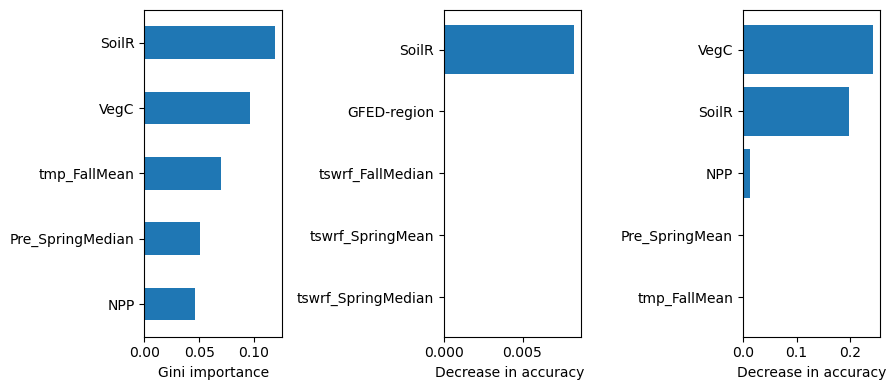

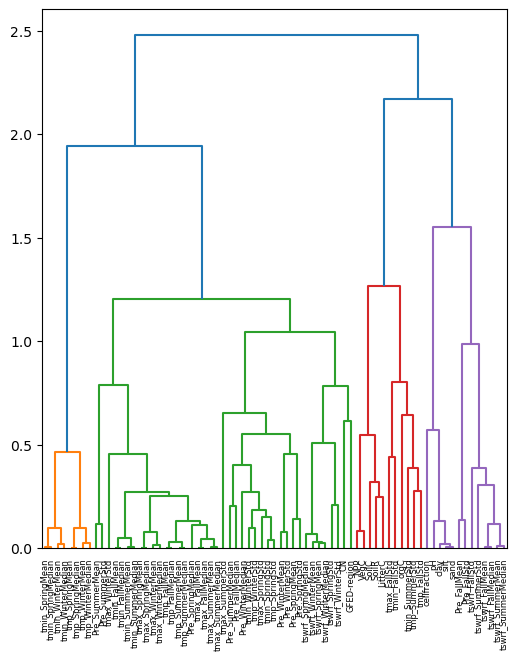

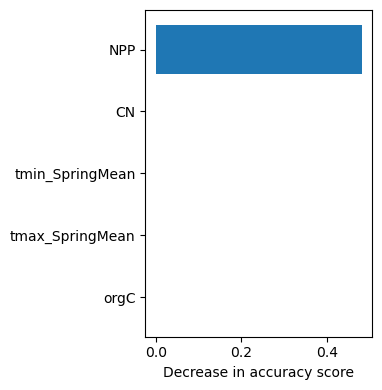

---

In [406]:
model_run(region_train_3, region_test_3, objective_list=biome_list_3, future_plots=True, experiment_name='s3_basic')

And now run the model whilst removing the medians

In [407]:
features_median = [feature_name for feature_name in list(data_index_2) if feature_name[-6:]=='Median']
print(f'We dropped the features: {features_median}')

model_run(region_train_3, region_test_3, objective_list=biome_list_3, drop_columns=features_median, experiment_name='s3_dropMedian')

We dropped the features: ['tmax_SpringMedian', 'tmax_SummerMedian', 'tmax_FallMedian', 'tmax_WinterMedian', 'tswrf_SpringMedian', 'tswrf_SummerMedian', 'tswrf_FallMedian', 'tswrf_WinterMedian', 'tmin_SpringMedian', 'tmin_SummerMedian', 'tmin_FallMedian', 'tmin_WinterMedian', 'tmp_SpringMedian', 'tmp_SummerMedian', 'tmp_FallMedian', 'tmp_WinterMedian', 'Pre_SpringMedian', 'Pre_SummerMedian', 'Pre_FallMedian', 'Pre_WinterMedian']
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9919
Balanced accuracy of RandomForestClassifier on train data: 0.9912


---
 The confusion table

Truth,16,17
Predicted,,
16,477,6
17,1,383


,precision,recall,f1-score,support
16,0.987578,0.997908,0.992716,478.000000
17,0.997396,0.984576,0.990944,389.000000
accuracy,0.991926,0.991926,0.991926,0.991926
macro avg,0.992487,0.991242,0.991830,867.000000
weighted avg,0.991983,0.991926,0.991921,867.000000


---
 The feature importance

,importance
SoilR,0.143831
VegC,0.087635
NPP,0.069610
Pre_SpringMean,0.064470
tmp_FallMean,0.058189
Pre_WinterMean,0.048003
Pre_WinterStd,0.042217
tmin_FallMean,0.039417
tmp_SummerMean,0.034553
tswrf_WinterMean,0.031324


---

Let's see how important the weather is.

In [408]:
features_weather = [feature_name for feature_name in list(data_index_2) if \
                   re.search('Fall|Summer|Winter|Spring',feature_name)]
print(f'We dropped the features: {features_weather}')
display(Markdown('---'))

model_run(region_train_3, region_test_3, objective_list=biome_list_3, drop_columns=features_weather, experiment_name='s3_dropWeather')

We dropped the features: ['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMean

---

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9663 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9931
Balanced accuracy of RandomForestClassifier on train data: 0.9925


---
 The confusion table

Truth,16,17
Predicted,,
16,477,5
17,1,384


,precision,recall,f1-score,support
16,0.989627,0.997908,0.993750,478.00000
17,0.997403,0.987147,0.992248,389.00000
accuracy,0.993080,0.993080,0.993080,0.99308
macro avg,0.993515,0.992527,0.992999,867.00000
weighted avg,0.993115,0.993080,0.993076,867.00000


---
 The feature importance

,importance
SoilR,0.318373
VegC,0.194957
NPP,0.183975
SoilC,0.078456
LitterC,0.076630
clay,0.036141
cellfraction,0.027651
sand,0.025204
pH,0.017084
silt,0.014798


---

What effect do the different seasons have?

In [409]:
seasons = ['Fall','Summer','Winter','Spring']
features_seasons = [[feature_name for feature_name in list(data_index_2) if \
                   re.search(season,feature_name)] for season in seasons]

for i,season in enumerate(seasons):
    print(f'Dropping season {season}')
    model_run(region_train_3, region_test_3, objective_list=biome_list_3, \
               drop_columns=features_seasons[i], experiment_name=f's3_drop_{season}')

Dropping season Fall
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9400
Balanced accuracy of RandomForestClassifier on train data: 0.9334


---
 The confusion table

Truth,16,17
Predicted,,
16,477,51
17,1,338


,precision,recall,f1-score,support
16,0.903409,0.997908,0.948310,478.000000
17,0.997050,0.868895,0.928571,389.000000
accuracy,0.940023,0.940023,0.940023,0.940023
macro avg,0.950230,0.933401,0.938441,867.000000
weighted avg,0.945423,0.940023,0.939454,867.000000


---
 The feature importance

,importance
SoilR,0.113081
NPP,0.075368
VegC,0.074045
Pre_WinterMean,0.069700
Pre_WinterMedian,0.064192
Pre_SpringMean,0.053945
Pre_SpringMedian,0.052056
Pre_WinterStd,0.037603
tswrf_SpringMean,0.033213
tswrf_WinterMean,0.031864


---

Dropping season Summer
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9308
Balanced accuracy of RandomForestClassifier on train data: 0.9234


---
 The confusion table

Truth,16,17
Predicted,,
16,476,58
17,2,331


,precision,recall,f1-score,support
16,0.891386,0.995816,0.940711,478.000000
17,0.993994,0.850900,0.916898,389.000000
accuracy,0.930796,0.930796,0.930796,0.930796
macro avg,0.942690,0.923358,0.928804,867.000000
weighted avg,0.937423,0.930796,0.930027,867.000000


---
 The feature importance

,importance
SoilR,0.115421
NPP,0.078965
Pre_WinterMean,0.078209
VegC,0.073566
Pre_WinterMedian,0.066785
Pre_SpringMean,0.053857
Pre_SpringMedian,0.046223
Pre_WinterStd,0.032143
tswrf_SpringMean,0.029890
tmin_FallMedian,0.028633


---

Dropping season Winter
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9769
Balanced accuracy of RandomForestClassifier on train data: 0.9745


---
 The confusion table

Truth,16,17
Predicted,,
16,477,19
17,1,370


,precision,recall,f1-score,support
16,0.961694,0.997908,0.979466,478.000000
17,0.997305,0.951157,0.973684,389.000000
accuracy,0.976932,0.976932,0.976932,0.976932
macro avg,0.979499,0.974532,0.976575,867.000000
weighted avg,0.977671,0.976932,0.976872,867.000000


---
 The feature importance

,importance
SoilR,0.110845
VegC,0.089777
NPP,0.075379
Pre_SpringMean,0.052803
Pre_SpringMedian,0.051670
tswrf_SpringMean,0.040491
tmp_SummerMean,0.036545
tmp_SummerMedian,0.034106
tmp_FallMedian,0.033158
tmin_SummerMean,0.031910


---

Dropping season Spring
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9781
Balanced accuracy of RandomForestClassifier on train data: 0.9758


---
 The confusion table

Truth,16,17
Predicted,,
16,477,18
17,1,371


,precision,recall,f1-score,support
16,0.963636,0.997908,0.980473,478.000000
17,0.997312,0.953728,0.975033,389.000000
accuracy,0.978085,0.978085,0.978085,0.978085
macro avg,0.980474,0.975818,0.977753,867.000000
weighted avg,0.978746,0.978085,0.978032,867.000000


---
 The feature importance

,importance
SoilR,0.120728
Pre_WinterMean,0.086957
VegC,0.081312
NPP,0.076829
Pre_WinterMedian,0.063743
Pre_WinterStd,0.045300
tmp_FallMedian,0.037575
tmin_FallStd,0.028709
tswrf_WinterMean,0.026362
SoilC,0.025530


---

Dropping autumn or summer had the biggest impact. Dropping spring and winter the least. Dropping the seasons does negatively effect our model. Now we test the different weather parameters.

In [410]:
weather_params = ['pre','tmp|tmin|tmax','tswrf']
features_weather_params = [[feature_name for feature_name in list(data_index_2) if \
                   re.search(weather_param,feature_name)] for weather_param in weather_params]

for i,weather_param in enumerate(weather_params):
    print(f'Dropping the weather parameters {weather_param}')
    model_run(region_train_3, region_test_3, objective_list=biome_list_3, \
              drop_columns=features_weather_params[i], experiment_name=f'drop_{weather_param.replace("|","_")}')

Dropping the weather parameters pre
length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9850
Balanced accuracy of RandomForestClassifier on train data: 0.9835


---
 The confusion table

Truth,16,17
Predicted,,
16,477,12
17,1,377


OSError: [Errno 22] Invalid argument: "../table/drop_['pre', 'tmp|tmin|tmax', 'tswrf']_confTable.tex"

None of the weather parameters has a striking impact on performance. Now lets see if the model works only with weather data.

In [411]:
print(f'We only use the features: {features_weather}')
display(Markdown('---'))

model_run(region_train_3, region_test_3, objective_list=biome_list_3, \
          use_columns=features_weather, experiment_name='s3_useWeather')

We only use the features: ['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMea

---

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9509 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.5502
Balanced accuracy of RandomForestClassifier on train data: 0.4990


---
 The confusion table

Truth,16,17
Predicted,,
16,477,389
17,1,0


,precision,recall,f1-score,support
16,0.550808,0.997908,0.709821,478.000000
17,0.000000,0.000000,NaN,389.000000
accuracy,0.550173,0.550173,0.550173,0.550173
macro avg,0.275404,0.498954,0.709821,867.000000
weighted avg,0.303675,0.550173,0.709821,867.000000


---
 The feature importance

,importance
Pre_SpringMedian,0.071748
Pre_WinterMean,0.066330
tmin_FallMedian,0.055103
Pre_SpringMean,0.054281
Pre_WinterStd,0.053840
tmp_FallMean,0.048556
tmp_FallMedian,0.040753
tswrf_WinterMedian,0.038230
Pre_WinterMedian,0.037585
tmp_SummerMedian,0.036044


---

It performs terribly as would be expected if one removed the most important parameters.

## Section 4: Multiclass classification

Because of the significant negative impact on the learning outcome by choosing regions at very different latitudes we chose as regions
- for training: Russia
- for testing: Canada

In [412]:
region_train_4 = data_index_2['Pan_2007'] == 'Russia'
region_test_4 = data_index_2['Pan_2007'] == 'Canada'

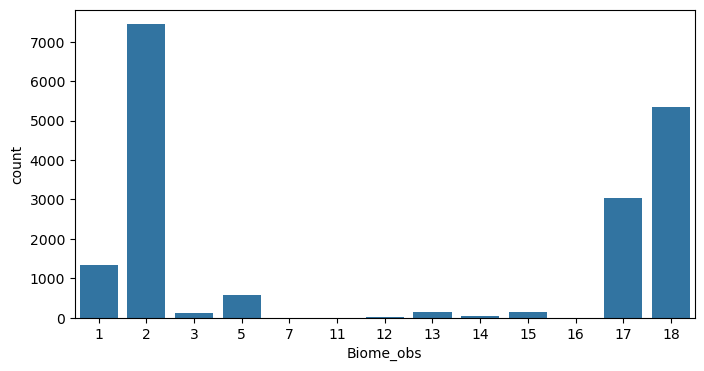

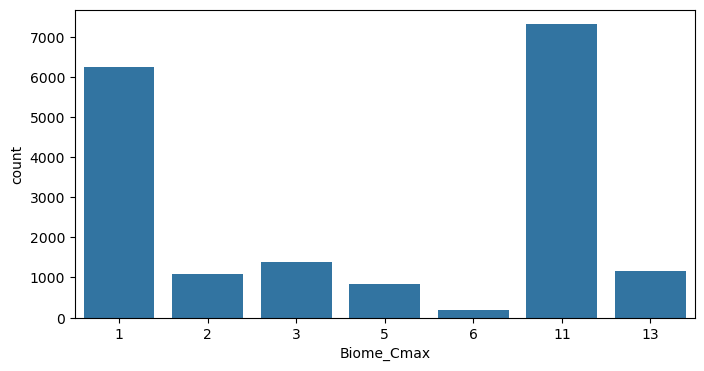

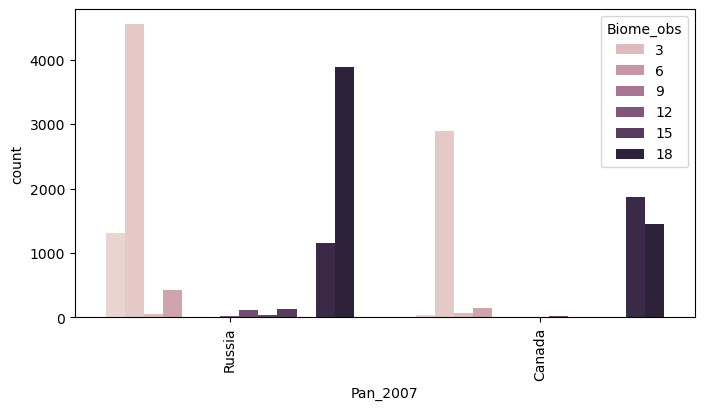

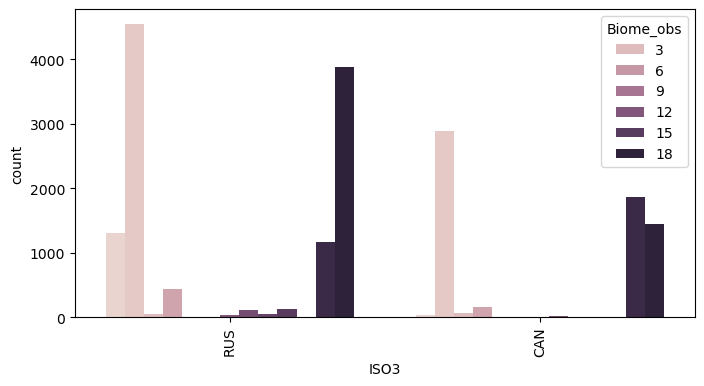

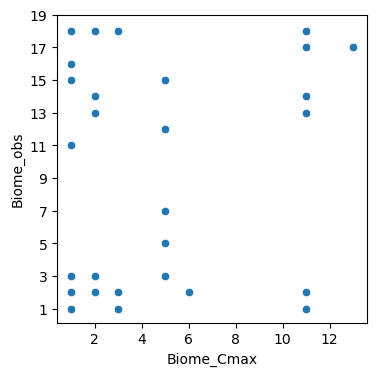

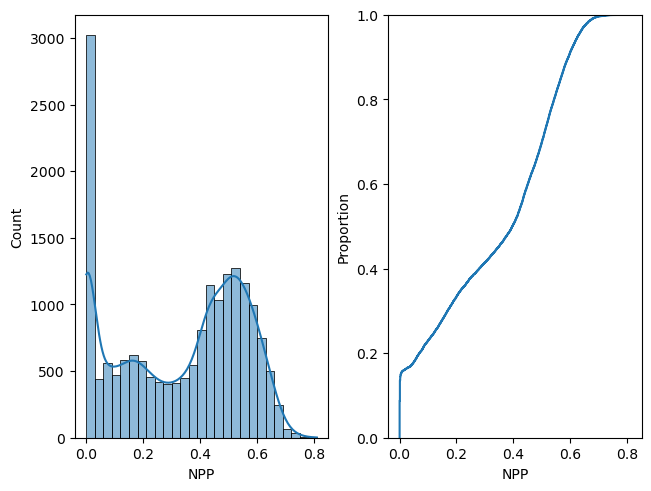

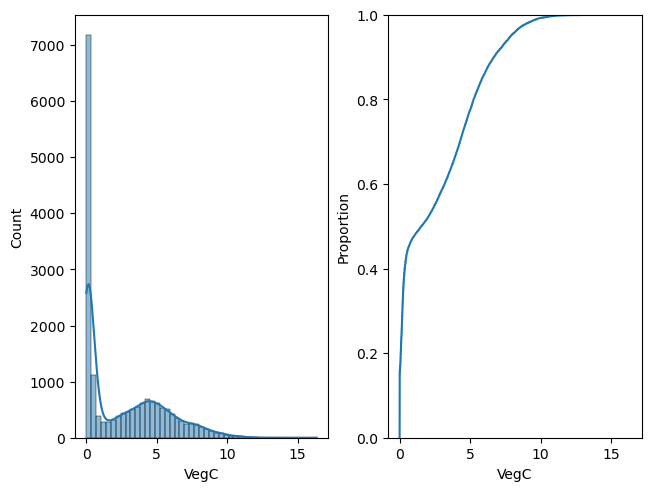

In [415]:
# plot the data
data1 = data_index_2.loc[region_train_4] 
data2 = data_index_2.loc[region_test_4]

data = pd.concat([data1,data2])
plot_statistics(data, name_data = 'Section4Canada_Russia')

And now we run the simulation

In [416]:
model_run(region_train_4, region_test_4, experiment_name = 'basic')

length of training data: 11696
length of testing data: 6497
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9793 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9603
Balanced accuracy of RandomForestClassifier on train data: 0.6615


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,24,94,0,0,0,0,0,0,0,2
2,4,2790,54,37,1,5,1,1,0,24
3,0,2,2,2,0,0,0,0,0,0
5,0,1,10,115,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,9,0,0,0,0
14,0,0,0,0,0,2,8,0,0,0
15,0,1,0,0,0,0,0,4,0,0
17,0,0,0,0,0,0,0,0,1869,5


,precision,recall,f1-score,support
1,0.200000,0.705882,0.311688,34.000000
2,0.956462,0.965064,0.960744,2891.000000
3,0.333333,0.030303,0.055556,66.000000
5,0.912698,0.746753,0.821429,154.000000
12,NaN,0.000000,NaN,1.000000
13,1.000000,0.500000,0.666667,18.000000
14,0.800000,0.888889,0.842105,9.000000
15,0.800000,0.800000,0.800000,5.000000
17,0.997332,0.999465,0.998397,1870.000000
18,0.991608,0.978606,0.985064,1449.000000


---
 The feature importance

,importance
VegC,0.150247
LitterC,0.077989
NPP,0.067365
tmp_WinterMean,0.042188
tmp_WinterMedian,0.039423
...,...
clay,0.000559
sand,0.000473
orgC,0.000342
CN,0.000333


---

This is relatively bad performance. Fiddling with the hyperparameters changes a lot though the
hyperparameter optimisation is far from optimal. Let's see how good it is.

length of training data: 6499
length of testing data: 11695
Max Depth:  5
Max Trees:  83
Min Leafs:  1
Max CV:  0.9444444444444445
Accuracy of RandomForestClassifier on train data: 0.9758
Balanced accuracy of RandomForestClassifier on train data: 0.4096
Accuracy RandomForestClassifier on cross validation: 0.9735 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.8462
Balanced accuracy of RandomForestClassifier on train data: 0.3590


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,483,0,0,0,0,0,0,0,0,2
2,729,4274,47,301,1,62,1,12,0,18
3,0,0,0,0,0,0,0,0,0,0
5,0,3,3,130,25,0,0,116,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,1146,3


,precision,recall,f1-score,support
1,0.995876,0.370399,0.539966,1304.000000
2,0.784940,0.938928,0.855057,4552.000000
3,NaN,0.000000,NaN,50.000000
5,0.469314,0.301624,0.367232,431.000000
12,NaN,0.000000,NaN,26.000000
13,NaN,0.000000,NaN,114.000000
14,NaN,0.000000,NaN,41.000000
15,NaN,0.000000,NaN,128.000000
17,0.997389,0.985383,0.991349,1163.000000
18,0.890297,0.994081,0.939331,3886.000000


---
 The feature importance

,importance
VegC,0.139920
NPP,0.091874
SoilR,0.083441
LitterC,0.074615
tmp_FallMean,0.062269
...,...
cellfraction,0.000137
sand,0.000107
tswrf_FallStd,0.000087
silt,0.000076


Baseline accuracy on test data with features removed: 0.3948


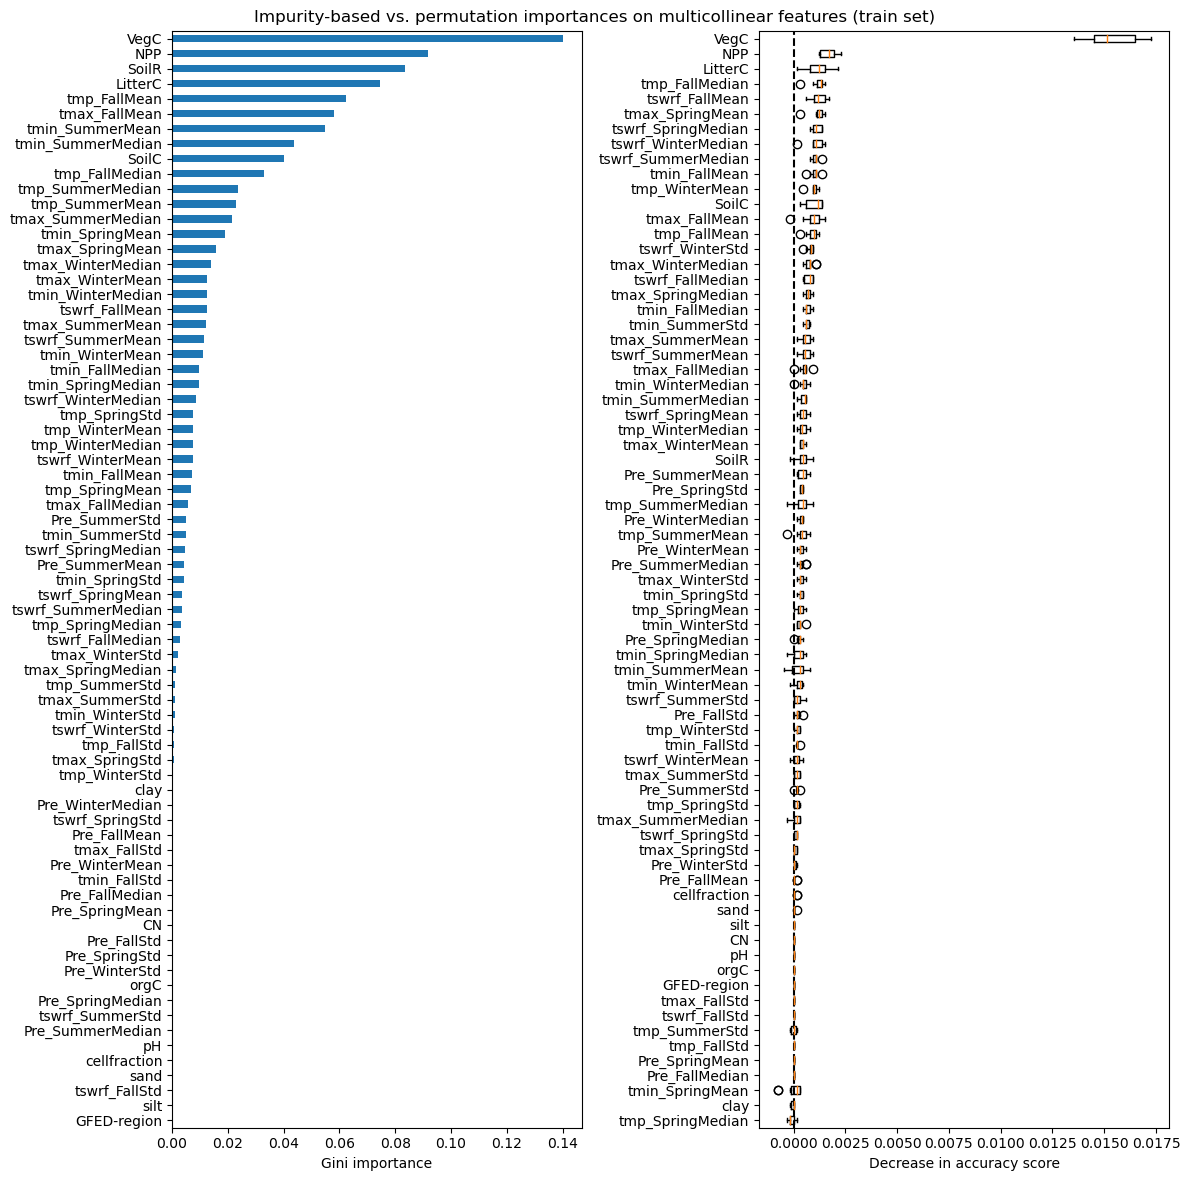

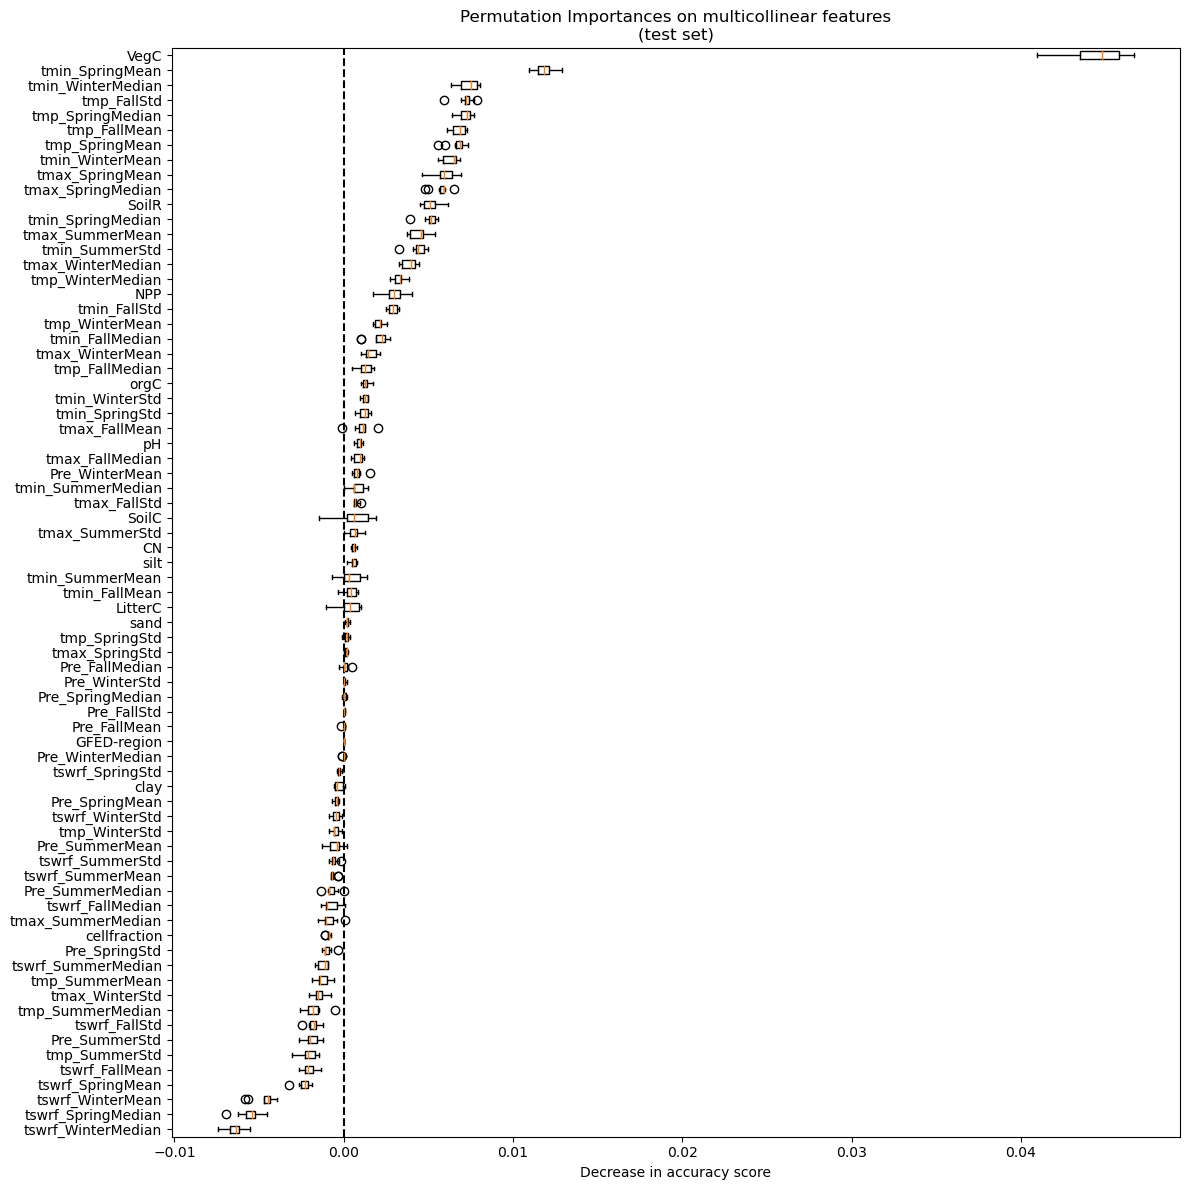

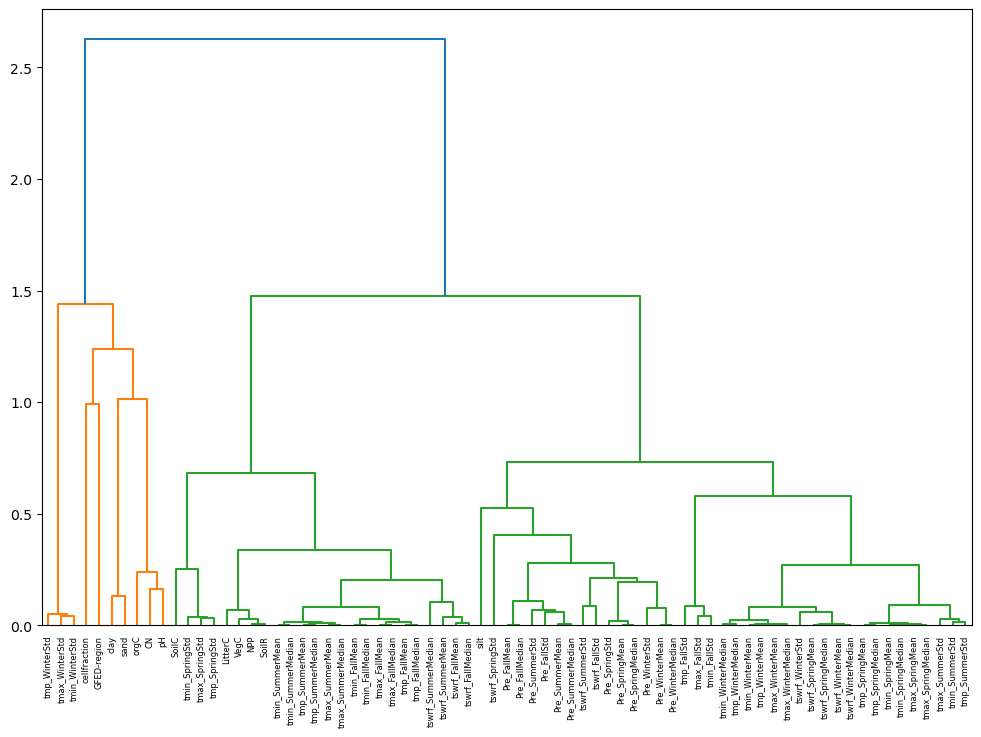

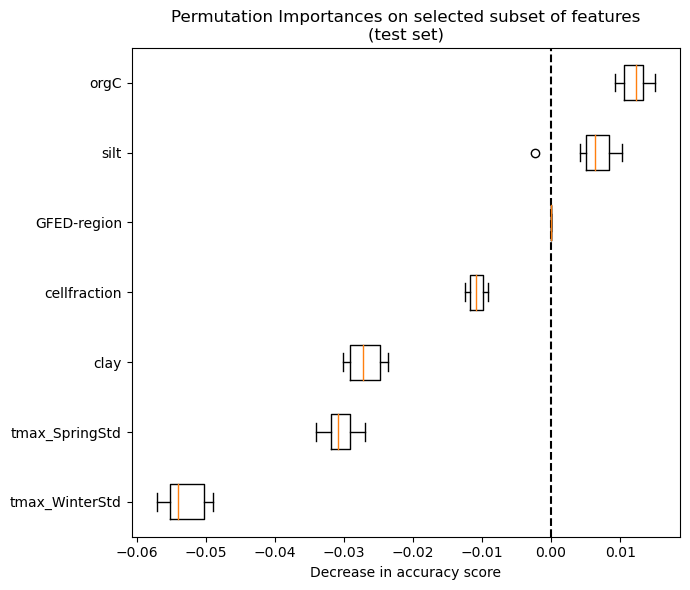

---

In [49]:
model_run(region_train_4, region_test_4, hyperparameter_tuning=True, experiment_name = 'Tuning')

It's not too good in this case. But when we were previously comparing Africa with China fiddling with the parameters actually did improve things. In the following we will thus disable the hyperparameter tuning. Let's see if things improve if we drop the features with medians.

length of training data: 6499
length of testing data: 11695
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9831 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9000
Balanced accuracy of RandomForestClassifier on train data: 0.4693


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,746,0,0,0,0,0,0,0,0,30
2,537,4481,40,130,4,6,0,40,0,11
3,0,2,3,60,0,0,0,0,0,0
5,0,14,7,241,0,0,0,26,0,0
12,0,0,0,0,0,0,0,0,0,0
13,1,0,0,0,2,4,0,0,0,0
14,0,0,0,0,0,0,1,0,0,0
15,0,0,0,0,20,0,0,62,0,0
17,0,0,0,0,0,0,0,0,1146,4


,precision,recall,f1-score,support
1,0.961340,0.572086,0.717308,1304.000000
2,0.853686,0.984402,0.914396,4552.000000
3,0.046154,0.060000,0.052174,50.000000
5,0.836806,0.559165,0.670376,431.000000
12,NaN,0.000000,NaN,26.000000
13,0.571429,0.035088,0.066116,114.000000
14,1.000000,0.024390,0.047619,41.000000
15,0.756098,0.484375,0.590476,128.000000
17,0.996522,0.985383,0.990921,1163.000000
18,0.942114,0.988420,0.964712,3886.000000


---
 The feature importance

,importance
VegC,0.150704
SoilR,0.098525
NPP,0.084936
tmax_FallMean,0.078871
LitterC,0.074350
SoilC,0.071400
tmp_FallMean,0.048510
tmin_SpringMean,0.044387
tswrf_FallMean,0.037999
tmp_SummerMean,0.030182


Baseline accuracy on test data with features removed: 0.6791


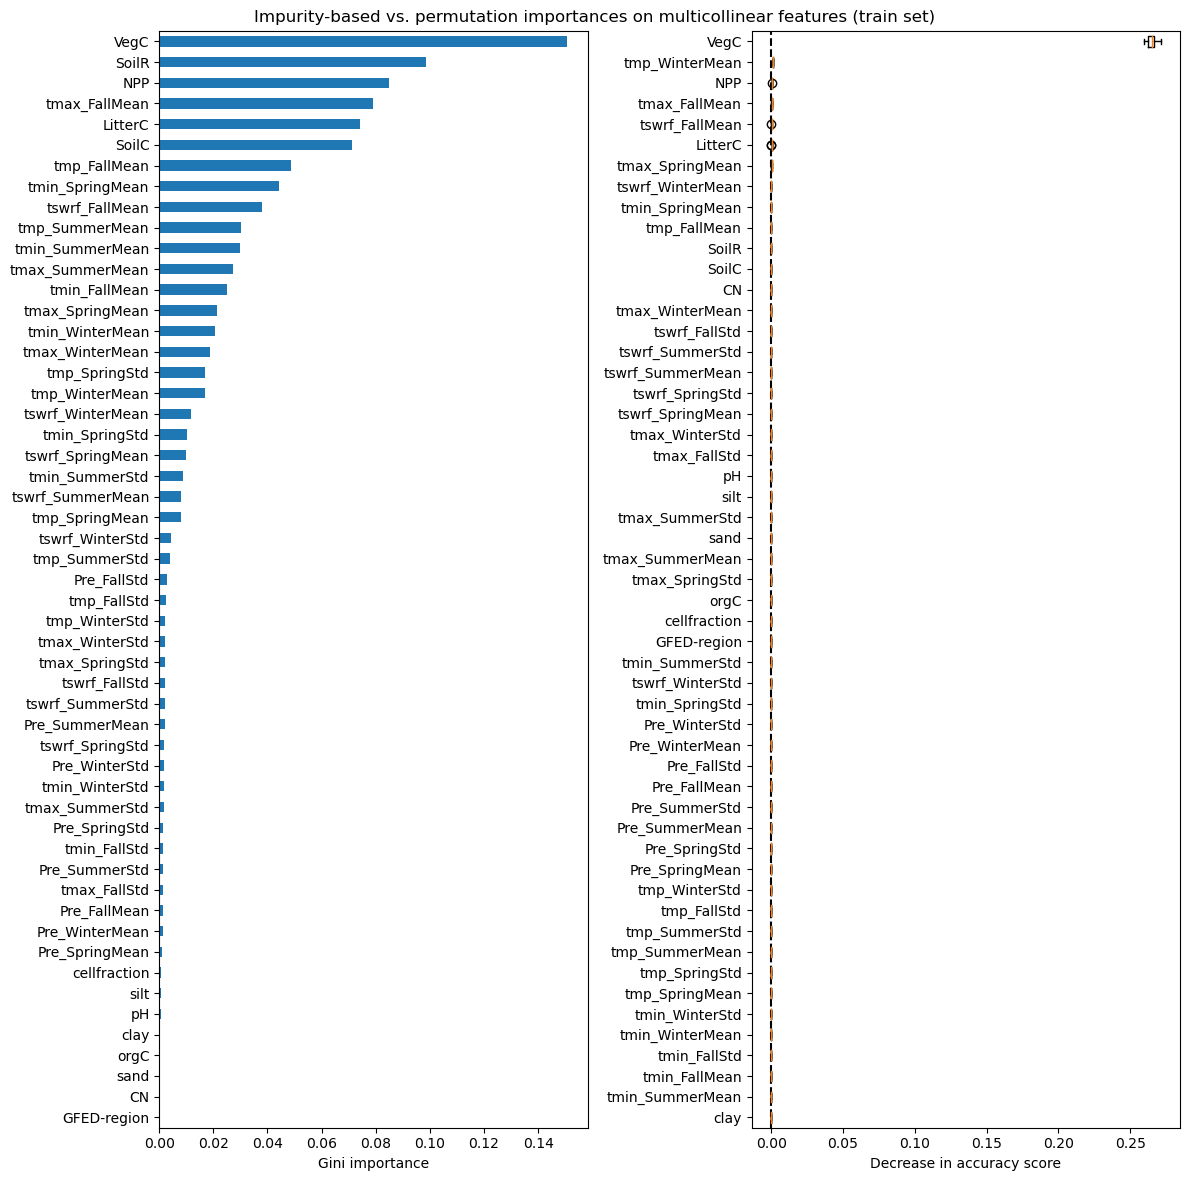

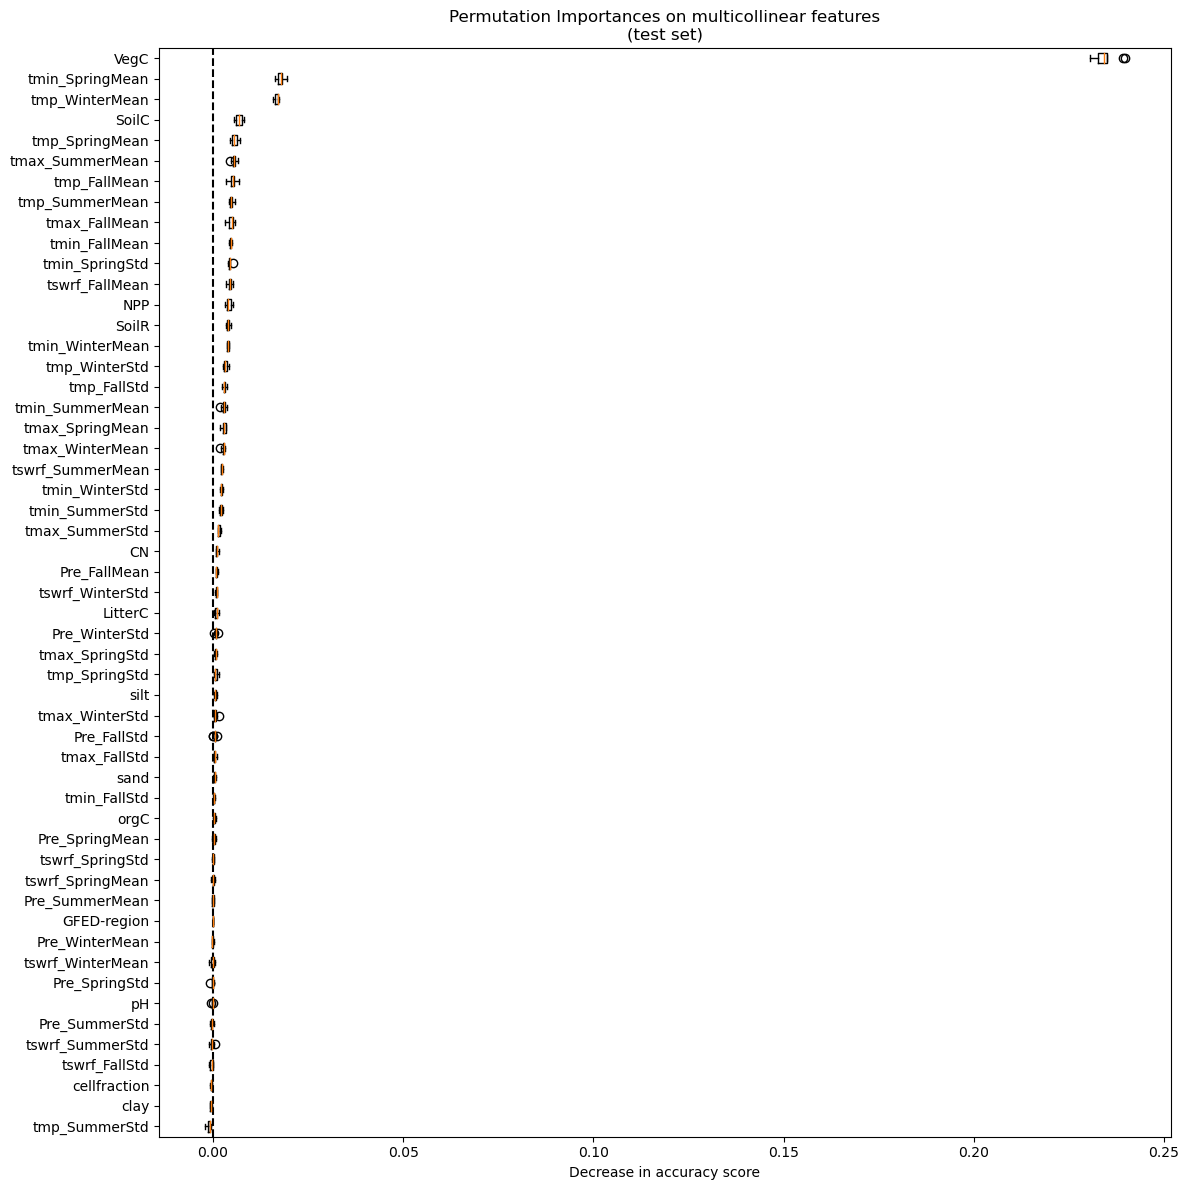

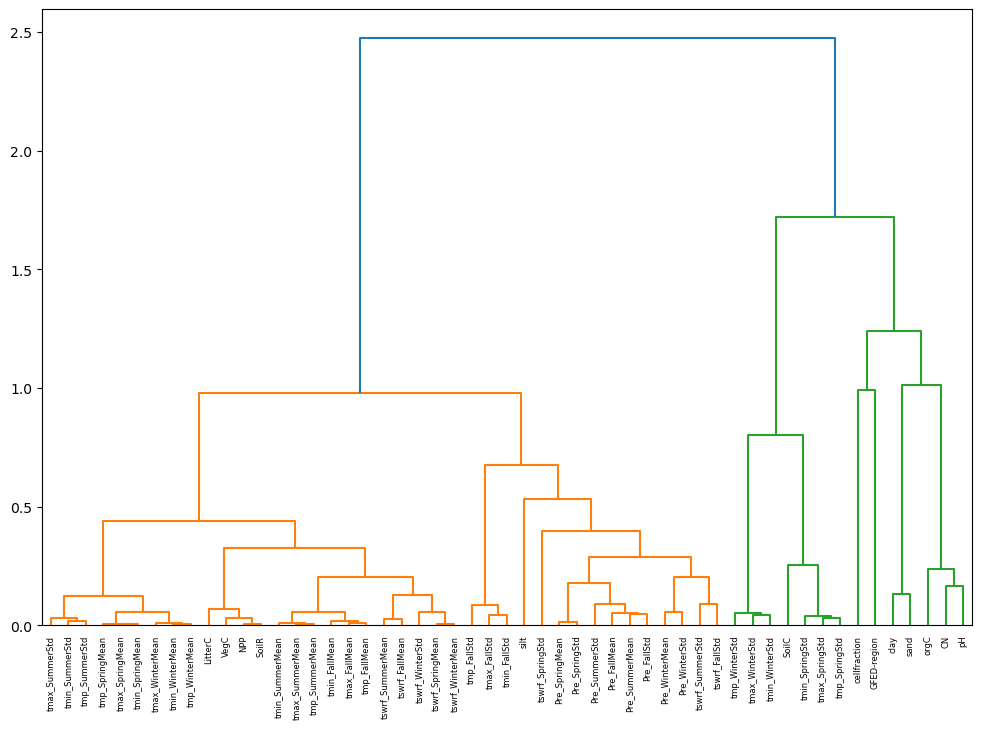

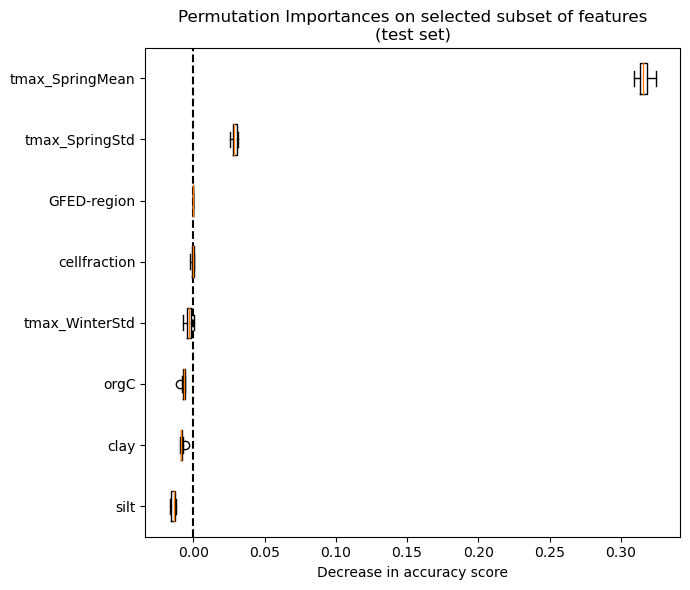

---

In [50]:
model_run(region_train_4, region_test_4, drop_columns=features_median)

That did not make much of a difference. Let's see what happens if we remove the entire weather data.

In [417]:
model_run(region_train_4, region_test_4, drop_columns=['VegC', 'LitterC', 'NPP'], experiment_name = "s4_VegC")

length of training data: 11696
length of testing data: 6497
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9634 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9318
Balanced accuracy of RandomForestClassifier on train data: 0.5549


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,25,90,0,0,0,0,0,0,0,11
2,1,2783,57,40,1,17,5,1,1,174
3,0,0,0,0,0,0,0,0,0,0
5,0,0,9,114,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,1,4,0,0,0
15,0,2,0,0,0,0,0,4,0,0
17,0,0,0,0,0,0,0,0,1866,6


,precision,recall,f1-score,support
1,0.198413,0.735294,0.312500,34.000000
2,0.903571,0.962643,0.932172,2891.000000
3,NaN,0.000000,NaN,66.000000
5,0.926829,0.740260,0.823105,154.000000
12,NaN,0.000000,NaN,1.000000
13,NaN,0.000000,NaN,18.000000
14,0.800000,0.444444,0.571429,9.000000
15,0.666667,0.800000,0.727273,5.000000
17,0.996795,0.997861,0.997328,1870.000000
18,0.978988,0.868185,0.920263,1449.000000


---
 The feature importance

,importance
SoilR,0.090197
SoilC,0.065142
tmin_WinterMean,0.053684
tmp_SpringMean,0.050266
tmin_SpringMean,0.047263
...,...
sand,0.001554
silt,0.001231
orgC,0.001213
CN,0.000918


---

In [418]:
model_run(region_train_4, region_test_4, use_columns=['VegC', 'LitterC', 'NPP'], experiment_name = "s4_VegC_use")

length of training data: 11696
length of testing data: 6497
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9164 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9315
Balanced accuracy of RandomForestClassifier on train data: 0.4131


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,8,163,1,0,0,0,0,0,0,8
2,21,2712,62,109,1,0,0,3,0,10
3,0,1,0,1,0,0,0,0,0,0
5,0,10,3,44,0,0,0,1,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,9,0,0,0,14
14,0,0,0,0,0,0,0,0,0,1
15,0,0,0,0,0,0,0,1,0,0
17,0,0,0,0,0,0,0,0,1870,8


,precision,recall,f1-score,support
1,0.044444,0.235294,0.074766,34.000000
2,0.929404,0.938084,0.933724,2891.000000
3,0.000000,0.000000,NaN,66.000000
5,0.758621,0.285714,0.415094,154.000000
12,NaN,0.000000,NaN,1.000000
13,0.391304,0.500000,0.439024,18.000000
14,0.000000,0.000000,NaN,9.000000
15,1.000000,0.200000,0.333333,5.000000
17,0.995740,1.000000,0.997866,1870.000000
18,0.980501,0.971705,0.976083,1449.000000


---
 The feature importance

,importance
VegC,0.389633
LitterC,0.320797
NPP,0.289570


---

That did not make much of a difference. Let's see what happens if we remove the entire weather data.

In [419]:
model_run(region_train_4, region_test_4, drop_columns=features_weather, experiment_name='s4_dropWeather')

length of training data: 11696
length of testing data: 6497
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9597 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9334
Balanced accuracy of RandomForestClassifier on train data: 0.3876


---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,11,68,0,0,0,0,0,0,0,8
2,17,2810,66,149,1,0,0,5,0,22
3,0,0,0,0,0,0,0,0,0,0
5,0,9,0,5,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,11,0,0,0,55
14,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,1870,7


,precision,recall,f1-score,support
1,0.126437,0.323529,0.181818,34.000000
2,0.915309,0.971982,0.942795,2891.000000
3,NaN,0.000000,NaN,66.000000
5,0.357143,0.032468,0.059524,154.000000
12,NaN,0.000000,NaN,1.000000
13,0.166667,0.611111,0.261905,18.000000
14,NaN,0.000000,NaN,9.000000
15,NaN,0.000000,NaN,5.000000
17,0.996271,1.000000,0.998132,1870.000000
18,0.981200,0.936508,0.958333,1449.000000


---
 The feature importance

,importance
VegC,0.277137
SoilR,0.156503
LitterC,0.148339
NPP,0.144977
SoilC,0.113657
orgC,0.022558
pH,0.022547
sand,0.021722
clay,0.021235
cellfraction,0.020693


---

We see that dropping fall decreased the performance the most whilst dropping the summer actually increased performance slightly. Let's see what happens if we use only weather data.

In [420]:
print(features_weather)
model_run(region_train_4, region_test_4, use_columns=features_weather, experiment_name='s4_useWeather')

['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMean', 'Pre_SummerMedian', 'P

---
 The confusion table

Truth,1,2,3,5,12,13,14,15,17,18
Predicted,,,,,,,,,,
1,17,120,0,0,0,0,0,0,0,12
2,0,2725,63,48,1,17,7,1,2,254
3,0,0,0,2,0,0,0,0,0,0
5,0,4,3,103,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0
14,0,1,0,0,0,1,2,0,4,0
15,0,1,0,1,0,0,0,4,0,0
17,0,0,0,0,0,0,0,0,1598,64


,precision,recall,f1-score,support
1,0.114094,0.500000,0.185792,34.000000
2,0.873958,0.942580,0.906973,2891.000000
3,0.000000,0.000000,NaN,66.000000
5,0.936364,0.668831,0.780303,154.000000
12,NaN,0.000000,NaN,1.000000
13,NaN,0.000000,NaN,18.000000
14,0.250000,0.222222,0.235294,9.000000
15,0.666667,0.800000,0.727273,5.000000
17,0.961492,0.854545,0.904870,1870.000000
18,0.776006,0.772257,0.774127,1449.000000


---
 The feature importance

,importance
tmp_FallMean,0.064355
tmin_SpringMean,0.060968
tmin_WinterMean,0.052461
tmin_WinterMedian,0.039353
tmp_FallMedian,0.039063
tmp_SpringMedian,0.037696
tmp_WinterMedian,0.037062
tmp_WinterMean,0.036015
tmin_SpringMedian,0.033639
tmp_SpringMean,0.031454


---

Turn's out that using only weather to classify biomes does not really go well. Let's see if the model works better at classifying 'Biome_Cmax'.

length of training data: 11696
length of testing data: 6499
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9551 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.9001
Balanced accuracy of RandomForestClassifier on train data: 0.7428


---
 The confusion table

Truth,1,2,3,5,11,13
Predicted,,,,,,
1,2411,368,2,29,19,0
2,1,2,0,0,0,0
3,121,1,22,0,3,0
5,15,21,0,172,0,0
11,11,3,7,0,2257,48
13,0,0,0,0,0,986


,precision,recall,f1-score,support
1,0.852245,0.942165,0.894952,2559.000000
2,0.666667,0.005063,0.010050,395.000000
3,0.149660,0.709677,0.247191,31.000000
5,0.826923,0.855721,0.841076,201.000000
11,0.970335,0.990347,0.980239,2279.000000
13,1.000000,0.953578,0.976238,1034.000000
accuracy,0.900138,0.900138,0.900138,0.900138
macro avg,0.744305,0.742759,0.658291,6499.000000
weighted avg,0.901750,0.900138,0.879253,6499.000000


---
 The feature importance

,importance
VegC,0.127284
LitterC,0.081275
NPP,0.050724
tmp_SpringMedian,0.040245
tmp_WinterMedian,0.039114
...,...
silt,0.001060
pH,0.000683
orgC,0.000629
CN,0.000456


<class 'pandas.core.indexes.base.Index'>
<class 'numpy.ndarray'>
<class 'pandas.core.indexes.base.Index'>
<class 'numpy.ndarray'>


y_pred contains classes not in y_true


Baseline accuracy on test data with features removed: 0.6343Baseline balanced accuracy on test data with features removed: 0.4916
<class 'pandas.core.indexes.base.Index'>
<class 'numpy.ndarray'>


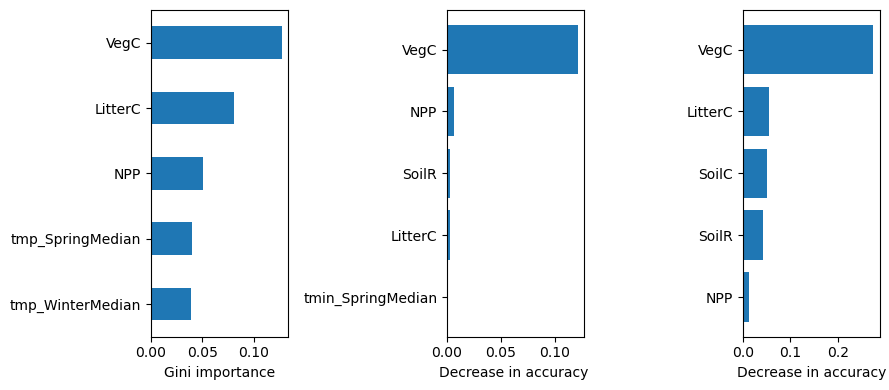

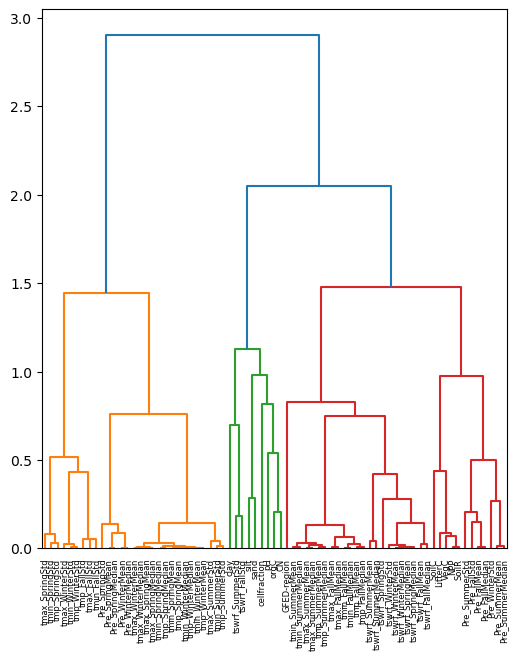

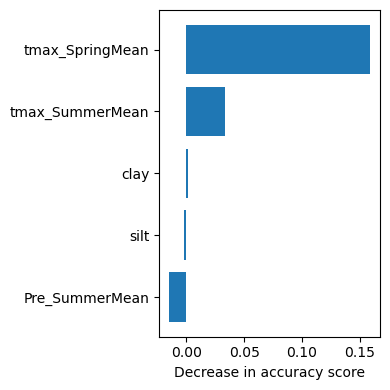

---

In [422]:
model_run(region_train_4, region_test_4, future_plots = True, objective='Biome_Cmax', experiment_name = 'Basic_with_Biome_Cmax')

In [424]:
model_run(region_train_4, region_test_4, hyperparameter_tuning=True, future_plots = False, objective='Biome_Cmax', experiment_name = 's4Basic_with_Biome_Cmax')

length of training data: 11696
length of testing data: 6499
Max Depth:  5
Max Trees:  83
Min Leafs:  1
Max CV:  0.7222222222222223
Accuracy of RandomForestClassifier on train data: 0.9388
Balanced accuracy of RandomForestClassifier on train data: 0.8385
Accuracy RandomForestClassifier on cross validation: 0.9325 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.8898
Balanced accuracy of RandomForestClassifier on train data: 0.7184


---
 The confusion table

Truth,1,2,3,5,11,13
Predicted,,,,,,
1,2484,339,5,18,47,0
2,0,0,0,0,0,0
3,45,1,19,0,1,0
5,23,53,0,183,0,0
11,7,2,7,0,2231,168
13,0,0,0,0,0,866


,precision,recall,f1-score,support
1,0.858624,0.970692,0.911225,2559.000000
2,NaN,0.000000,NaN,395.000000
3,0.287879,0.612903,0.391753,31.000000
5,0.706564,0.910448,0.795652,201.000000
11,0.923810,0.978938,0.950575,2279.000000
13,1.000000,0.837524,0.911579,1034.000000
accuracy,0.889829,0.889829,0.889829,0.889829
macro avg,0.755375,0.718417,0.792157,6499.000000
weighted avg,0.899005,0.889829,0.919533,6499.000000


---
 The feature importance

,importance
VegC,0.133306
LitterC,0.082895
tmp_SpringMedian,0.056519
NPP,0.055737
tmin_WinterMean,0.045522
...,...
Pre_WinterMean,0.000081
orgC,0.000068
CN,0.000048
cellfraction,0.000019


---

Plot for different features:

In [425]:
model_run(region_train_4, region_test_4, drop_columns=['VegC', 'LitterC', 'NPP'], objective='Biome_Cmax', experiment_name = 'S4_with_Biome_Cmax_dropVegC')

length of training data: 11696
length of testing data: 6499
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9384 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.7840
Balanced accuracy of RandomForestClassifier on train data: 0.6079


y_pred contains classes not in y_true


---
 The confusion table

Truth,1,2,3,5,6,11,13
Predicted,,,,,,,
1,2366,373,0,34,0,107,0
2,0,0,0,0,0,0,0
3,106,1,17,0,0,6,0
5,21,19,0,167,0,0,0
6,0,1,0,0,0,0,0
11,66,1,14,0,0,2116,605
13,0,0,0,0,0,50,429


,precision,recall,f1-score,support
1,0.821528,0.924580,0.870013,2559.000000
2,NaN,0.000000,NaN,395.000000
3,0.130769,0.548387,0.211180,31.000000
5,0.806763,0.830846,0.818627,201.000000
6,0.000000,NaN,NaN,0.000000
11,0.755175,0.928477,0.832907,2279.000000
13,0.895616,0.414894,0.567085,1034.000000
accuracy,0.783967,0.783967,0.783967,0.783967
macro avg,0.568309,0.607864,0.659963,6499.000000
weighted avg,0.805310,0.783967,0.799806,6499.000000


---
 The feature importance

,importance
SoilR,0.069635
tmp_SpringMean,0.054699
tmp_WinterMean,0.052859
tmin_WinterMean,0.048116
tmin_SpringMean,0.046670
...,...
silt,0.001470
pH,0.001241
orgC,0.001170
CN,0.001149


---

In [426]:
model_run(region_train_4, region_test_4, use_columns=['VegC', 'LitterC', 'NPP'], objective='Biome_Cmax', experiment_name = "s4_with_Biome_VegC_use")

length of training data: 11696
length of testing data: 6499
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.8803 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.8540
Balanced accuracy of RandomForestClassifier on train data: 0.6472


y_pred contains classes not in y_true


---
 The confusion table

Truth,1,2,3,5,6,11,13
Predicted,,,,,,,
1,1958,156,17,107,0,3,0
2,366,224,0,32,0,0,0
3,174,9,8,1,0,10,0
5,25,1,0,60,0,0,0
6,32,1,0,1,0,0,0
11,4,4,6,0,0,2266,0
13,0,0,0,0,0,0,1034


,precision,recall,f1-score,support
1,0.873717,0.765143,0.815833,2559.000000
2,0.360129,0.567089,0.440511,395.000000
3,0.039604,0.258065,0.068670,31.000000
5,0.697674,0.298507,0.418118,201.000000
6,0.000000,NaN,NaN,0.000000
11,0.993860,0.994296,0.994078,2279.000000
13,1.000000,1.000000,1.000000,1034.000000
accuracy,0.853978,0.853978,0.853978,0.853978
macro avg,0.566426,0.647183,0.622868,6499.000000
weighted avg,0.895301,0.853978,0.868963,6499.000000


---
 The feature importance

,importance
VegC,0.414103
LitterC,0.322706
NPP,0.263190


---

In [427]:
model_run(region_train_4, region_test_4, drop_columns=features_weather, objective='Biome_Cmax', experiment_name='s4_with_Biome_dropWeather')

length of training data: 11696
length of testing data: 6499
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9411 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.8841
Balanced accuracy of RandomForestClassifier on train data: 0.6611


---
 The confusion table

Truth,1,2,3,5,11,13
Predicted,,,,,,
1,2237,249,16,94,35,0
2,236,123,0,5,0,0
3,72,10,9,0,3,0
5,6,8,0,102,0,0
11,8,5,6,0,2241,0
13,0,0,0,0,0,1034


,precision,recall,f1-score,support
1,0.850247,0.874170,0.862042,2559.000000
2,0.337912,0.311392,0.324111,395.000000
3,0.095745,0.290323,0.144000,31.000000
5,0.879310,0.507463,0.643533,201.000000
11,0.991593,0.983326,0.987442,2279.000000
13,1.000000,1.000000,1.000000,1034.000000
accuracy,0.884136,0.884136,0.884136,0.884136
macro avg,0.692468,0.661112,0.660188,6499.000000
weighted avg,0.889800,0.884136,0.885088,6499.000000


---
 The feature importance

,importance
VegC,0.300748
LitterC,0.147020
NPP,0.131472
SoilR,0.130462
SoilC,0.113900
sand,0.025648
clay,0.025554
cellfraction,0.024660
orgC,0.021803
GFED-region,0.021795


---

In [428]:
model_run(region_train_4, region_test_4, use_columns=features_weather, objective='Biome_Cmax', experiment_name='s4_with_Biome_useWeather')

length of training data: 11696
length of testing data: 6499
Accuracy of RandomForestClassifier on train data: 1.0000
Balanced accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9289 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.7226
Balanced accuracy of RandomForestClassifier on train data: 0.5466


y_pred contains classes not in y_true


---
 The confusion table

Truth,1,2,3,5,6,11,13
Predicted,,,,,,,
1,2341,382,0,50,0,132,0
2,0,0,0,1,0,0,0
3,113,1,19,0,0,17,0
5,22,10,0,150,0,0,0
6,0,1,0,0,0,0,0
11,83,1,12,0,0,2098,946
13,0,0,0,0,0,32,88


,precision,recall,f1-score,support
1,0.805852,0.914810,0.856881,2559.000000
2,0.000000,0.000000,NaN,395.000000
3,0.126667,0.612903,0.209945,31.000000
5,0.824176,0.746269,0.783290,201.000000
6,0.000000,NaN,NaN,0.000000
11,0.668153,0.920579,0.774313,2279.000000
13,0.733333,0.085106,0.152513,1034.000000
accuracy,0.722573,0.722573,0.722573,0.722573
macro avg,0.451169,0.546611,0.555388,6499.000000
weighted avg,0.694376,0.722573,0.701027,6499.000000


---
 The feature importance

,importance
tmp_FallMean,0.068171
tmin_SpringMean,0.054223
tmin_WinterMean,0.050921
tmp_SpringMedian,0.050272
tmp_WinterMean,0.045452
tmin_FallMean,0.043427
tmp_WinterMedian,0.040944
tmp_SpringMean,0.036120
tmin_SpringMedian,0.033514
tmax_SpringMedian,0.029910


---

That is quite decent performance though not as good as with biome_obs.

## Section 4.6

Test the model trained with 'Biome_Cmax' on 'Biome_obs'.

In [ ]:
model_run(region_train_4, region_test_4, objective='Biome_Cmax', objective_test='Biome_obs')

Who would have thought? The model performs as badly as an antigen test measuring temperature. Now test the model trained on 'Biome_obs' on 'Biome_Cmax' (and expect a similar result).

In [ ]:
model_run(region_train_4, region_test_4, objective='Biome_obs', objective_test='Biome_Cmax')

... and the result is just as bad. What a surprise. Now compare our model with LPJ-Guess output

In [ ]:
for objective in ['Biome_obs','Biome_Cmax']:
    print(f'Comparing LPJ-Guess with our model for the parameter {objective}')
    model_run(region_train_4, region_test_4, objective=objective, objective_test=f'LPJ_{objective}')

Who would have thought that our model works badly in this case (duh)?

## Section 5: Regression 

In this part we creatively use the same test and validation set as in part 4. Though we swap order because of performance issues

In [ ]:
region_train_5 = region_test_4
region_test_5 = region_train_4

In [ ]:
# plot the data
data1 = data_index_2.loc[region_train_5] 
data2 = data_index_2.loc[region_test_5]

data = pd.concat([data1,data2])
plot_statistics(data, name_data = 'Section5Canada_Russia')

And we run the model.

In [ ]:
performance = model_run(region_train_5, region_test_5, objective='NPP', continuous_Y=True, future_plots=False)

simulation_comparisons = pd.DataFrame([['base']+performance], columns=['experiment name', 'R^2 score, train', 'score, test', 'MSE, test', 'MSE sktfct, test', 'sqrt(MSE)', 'max err', 'mean abs err'])

A pretty decent outcome. Let's see how it behaves with 'VegC'.

In [ ]:
performance = model_run(region_train_5, region_test_5, objective='VegC', continuous_Y=True, future_plots=True)

'VegC' seems to perform worse. In the following we focus on NPP. What happens if we drop the medians?

In [ ]:
features_median = [feature_name for feature_name in list(data_index_2) if feature_name[-6:]=='Median']

performance = model_run(region_train_5, region_test_5, objective='NPP', continuous_Y=True, drop_columns=features_median)

simulation_comparisons = pd.concat([simulation_comparisons, pd.DataFrame([['drop meadians']+performance], columns=list(simulation_comparisons))])

We analyse the importance of the weather on the prediction.

In [ ]:
features_weather = [feature_name for feature_name in list(data_index_2) if \
                   re.search('Fall|Summer|Winter|Spring',feature_name)]
performance = model_run(region_train_5, region_test_5, objective='NPP', continuous_Y=True, \
          drop_columns=features_weather, future_plots=True)
simulation_comparisons = pd.concat([simulation_comparisons, pd.DataFrame([['drop weather']+performance], columns=list(simulation_comparisons))])

Let's look at the different seasons

In [ ]:
seasons = ['Fall','Summer','Winter','Spring']
features_seasons = [[feature_name for feature_name in list(data_index_2) if \
                   re.search(season,feature_name)] for season in seasons]

for i,season in enumerate(seasons):
    print(f'Dropping season {season}')
    performance = model_run(region_train_5, region_test_5, objective='NPP', continuous_Y=True, \
               drop_columns=features_seasons[i], experiment_name=f's5_drop_{season}')
    simulation_comparisons = pd.concat([simulation_comparisons, pd.DataFrame([[f'drop {season}']+performance], columns=list(simulation_comparisons))])

And now let's look at the different weather parameters

In [ ]:
weather_params = ['pre','tmp|tmin|tmax','tswrf']
features_weather_params = [[feature_name for feature_name in list(data_index_2) if \
                   re.search(weather_param,feature_name)] for weather_param in weather_params]

for i,weather_param in enumerate(weather_params):
    print(f'Dropping the weather parameters {weather_param}')
    performance = model_run(region_train_5, region_test_5, objective='NPP', continuous_Y=True, \
              drop_columns=features_weather_params[i], experiment_name=f's5_drop_{weather_param.replace("|","_")}')
    simulation_comparisons = pd.concat([simulation_comparisons, pd.DataFrame([[f'drop {weather_param}']+performance], columns=list(simulation_comparisons))])

What happens if we only use weather data?

In [ ]:
performance = model_run(region_train_5, region_test_5, objective='NPP', continuous_Y=True, use_columns=features_weather, future_plots=True)

simulation_comparisons = pd.concat([simulation_comparisons, pd.DataFrame([['only weather']+performance], columns=list(simulation_comparisons))])

In [ ]:
simulation_comparisons = simulation_comparisons.set_index(['experiment name'])
df_to_latex(simulation_comparisons.drop(columns=['R^2 score, train', 'MSE, test', 'MSE sktfct, test']), 's5_experiment_comparison')